# Projet 7 - <font color='green'>Notebook</font> - Implémentez un modèle de scoring
Dans ce projet, nous agissons pour un organisme de crédit à la consommation dans le but de mettre en œuvre:
- un modèle de “scoring crédit” s’appuyant sur des sources de données variées ;
- un dashboard interactif pour aider les chargés de relation client à présenter la décision d’octroi et leur permettre d’échanger de manière transparente avec leurs clients.

Le projet se compose en 4 phases :
- Prise de connaissance du jeu de données comprenant l'assemblage du jeu, le preprocessing et le feature engineering ;
- Modélisation "technique" de la décision d'octroi du prêt, en fonction du risque de défaut de paiement du client, comprenant la recherche du meilleur modèle et son optimisation ;
- Modélisation "métier" tenant compte de la problématique métier quant aux impacts des erreurs de prédictions, et de l'interprétabilité du modèle ainsi déterminé ;
- Elaboration et déploiement d'un dashboard interactif pour aider les chargés de relation client à présenter la décision d’octroi et leur permettre d’échanger de manière transparente avec leurs clients.

Le projet est réalisé en python 3.9 et les versions des principales librairies utilisées figurent dans le fichier 'requirements.txt' ainsi que dans le présent notebook.

<a id="sommaire"></a>
## Sommaire
1. [Initialisations](#init)
&nbsp;
2. [Prise de connaissance du jeu de données](#files)
    1. [Lecture des fichiers](#file_reading)
    2. [Fichiers spécifiques et jeu de données](#specific_files)
    3. [Tables des relations entre les fichiers du jeu de données](#dataset_tables)
    4. [Graphe des relations entre les fichiers du jeu de données](#dataset_graph)
    5. [Organisation du jeu de données présenté par Kaggle](#dataset_org)
    5. [Éléments de compréhension du jeu de données](#dataset_keys)
3. [Preprocessing des données](#preprocessing)
    1. [Constitution du jeu de données](#pp_aguiar)
    2. [Traitement des valeurs manquantes](#pp_nan)
    3. [Vérification du preprocessing avec la modélisation LightGBM d'Aguiar](#lgbm_aguiar)
        1. [Sans prétraitement des manquants](#lgbm_aguiar_withNaN)
        2. [Avec traitement préalable des manquants en mode automatique](#lgbm_aguiar_w0NaN_auto)
        3. [Avec traitement préalable des manquants contenant des décisions spécifiques](#lgbm_aguiar_w0NaN_forced)
    4. [Conclusion sur le preprocessing](#pp_conclusion)
4. [Recherche du meilleur modèle de classification](#model_research)
    1. [Choix de métrique](#model_metrics)
    2. [Normalisation des features numériques](#model_norm)
        1. [Jeu de données avec nan traitées de manière auto](#model_norm_auto)
        2. [Jeu de données avec nan traitées avec décisions](#model_norm_forced)
    3. [Recherche du meilleur modèle](#model_steps)
        1. [Baseline et modèles cibles à tester et comparer](#model_list)
        2. [Optimisation des hyperparamètres des modèles cibles](#model_opti)
        3. [Enregistrement des meilleurs hyperparamètres](#model_save_hp)
        4. [Comparaison et sélection du modèle](#model_selection)
        5. [Optimisation du modèle sélectionné](#model_opti_selected)
5. [Approche métier](#Model_business)
    1. [Optimisation du modèle du point de vue métier](#Model_buss_opti)
    2. [Analyse de l'impact des features](#Model_buss_shap)



<a id="init"></a>
# 1 - Initialisations

In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import json
from tqdm.notebook import tqdm

# Mesure du temps de calcul:
#import timeit
#start_time = timeit.default_timer()
# ... code dont on veut mesurer la durée ...
#elapsed = timeit.default_timer() - start_time
#print(f"Temps de calcul {fct.elapsed_format(elapsed)}")

# Pour afficher les graphiques dans le Notebook
%matplotlib inline
# Pour afficher les graphiques dans une fenêtre matplotlib
#%matplotlib qt

# Display options
from IPython.display import display, display_html, display_png, display_svg, Image
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 199)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

# Colorama
from colorama import init, Fore, Back, Style
#init()
# Fore: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Back: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Style: DIM, NORMAL, BRIGHT, RESET_ALL

# Affiche les versions de Python et packages généraux utilisés
print(Fore.BLACK + Style.BRIGHT + Back.WHITE
      + 'Versions de Python et des principales librairies utilisées :\n' +
      Style.RESET_ALL)
print('- Python : ' + sys.version)
print('- Numpy : ' + np.__version__)
print('- Pandas : ' + pd.__version__)
print('- Matplotlib : ' + mpl.__version__)
print('- Seaborn : ' + sns.__version__)

# Fonctions support du projet
from P7_functions import *

# Version de jupyter
!jupyter --version

Versions de Python et des principales librairies utilisées :

- Python : 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
- Numpy : 1.21.5
- Pandas : 1.4.3
- Matplotlib : 3.5.2
- Seaborn : 0.11.2
- Version de la librairie networkx : 2.8.4
Versions des librairies des modèles:
- Scikit-learn : 1.1.1
- LightGBM : 3.2.1
Version de la librairie Optuna: 3.0.1 

Selected Jupyter core packages...
IPython          : 8.4.0
ipykernel        : 6.15.2
ipywidgets       : 7.6.5
jupyter_client   : 7.3.5
jupyter_core     : 4.10.0
jupyter_server   : 1.13.5
jupyterlab       : 3.2.9
nbclient         : 0.5.13
nbconvert        : 6.4.4
nbformat         : 5.3.0
notebook         : 6.4.12
qtconsole        : 5.3.2
traitlets        : 5.1.1


[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="files"></a>
## 2 - Prise de connaissance du jeu de données

<a id="file_reading"></a>
### 2.1 - Lecture des fichiers

In [2]:
# Prise de connaissance du package de fichiers
run_change_sep = False # Exécute le changement de séparateur csv si True

# Liste des fichiers de données
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Liste des fichiers de données:\n" + Style.RESET_ALL)
list_filepath = list_dir(input_data_path, extension='*.csv', verbose=True)
print('\n')

# Changement du séparateur des fichiers csv pour lecture directe avec MS-Excel
if run_change_sep:
    suffix = 'xl'
    print(Fore.BLACK + Style.BRIGHT + Back.WHITE
          + f"Les fichiers avec nouveau séparateur sont dans le sous-répertoire {suffix}\n"
          + Style.RESET_ALL)
    for filename in list_filepath:
        change_csv_sep(filename, old_csv=',', new_csv=';', suffix=suffix)

    # Nettoyage des données
    del suffix
    gc.collect()

Liste des fichiers de données:

Liste des 10 fichiers de './P7_data/input_data/*.csv':
 → application_test.csv
 → application_train.csv
 → bureau.csv
 → bureau_balance.csv
 → credit_card_balance.csv
 → HomeCredit_columns_description.csv
 → installments_payments.csv
 → POS_CASH_balance.csv
 → previous_application.csv
 → sample_submission.csv




[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="specific_files"></a>
### 2.2 - Fichiers spécifiques et jeu de données
Le fichier "application_test.csv" concerne l'échantillon de test de la modélisation pour livrer la prédiction. Il est associé au fichier "sample_submission.csv" qui donne l'exemple de soumission des prédictions ('TARGET'), lui-même ne présentant donc pas d'intérêt pour notre projet.

Le fichier "application_train.csv" contient les mêmes informations que "application_test.csv" avec, de plus, la variable cible ('TARGET') pour l'entrainement du modèle. C'est le fichier central pour l'entrainement du modèle.

Le fichier "HomeCredit_columns_description" donne la description des features du jeu de données, utile pour la compréhension du jeu de donnée, mais n'apporte pas de features d'entrée pour le machine learning.

Pour l'analyse ci-après des relations entre les fichiers de données, nous ne considérerons donc pas les 2 fichiers "sample_submission.csv" et "HomeCredit_columns_description".

In [3]:
# Suppression des fichiers "sample_submission.csv" et "HomeCredit_columns_description" de la liste
del list_filepath[5]
del list_filepath[8]

# Liste des fichiers du jeu de données
filenames = []
for path in list_filepath:
    filenames.append(os.path.basename(path)[:-4])
print(Fore.BLACK + Style.BRIGHT + Back.WHITE
      + f"Liste des {len(filenames)} fichiers du jeu de données:\n"
      + Style.RESET_ALL)
for fn in filenames:
    print(f' - {fn}')
print('\n')

# Dictionnaire des features: {features: [liste des fichiers de données]}
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Établissement du dictionnaire des features\n" + Style.RESET_ALL)
features_dict = get_features_dict(list_filepath, verbose=True)
fns_features_dict = sort_n_filter_features_dict(features_dict, verbose=True)

# Nettoyage des données
del list_filepath, path, fn
gc.collect()

Liste des 8 fichiers du jeu de données:

 - application_test
 - application_train
 - bureau
 - bureau_balance
 - credit_card_balance
 - installments_payments
 - POS_CASH_balance
 - previous_application


Établissement du dictionnaire des features

Lecture des features du fichier 'application_test'
 → 121 features sur 121 ajoutées au dictionnaire
Lecture des features du fichier 'application_train'
 → 1 features sur 122 ajoutées au dictionnaire
Lecture des features du fichier 'bureau'
 → 15 features sur 17 ajoutées au dictionnaire
Lecture des features du fichier 'bureau_balance'
 → 2 features sur 3 ajoutées au dictionnaire
Lecture des features du fichier 'credit_card_balance'
 → 21 features sur 23 ajoutées au dictionnaire
Lecture des features du fichier 'installments_payments'
 → 6 features sur 8 ajoutées au dictionnaire
Lecture des features du fichier 'POS_CASH_balance'
 → 2 features sur 8 ajoutées au dictionnaire
Lecture des features du fichier 'previous_application'
 → 27 features sur

518

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="dataset_tables"></a>
### 2.3 - Tables des relations entre les fichiers du jeu de données
Constitution de 2 tables donnant les relations entre les fichiers de données:
- les noms des fichiers de données sont en ligne et colonne et la valeur indique la relation entre la paire de fichiers de données ;
- df_nrel: nombre de features communes à la paire de fichiers ;
- df_feat: liste des features communes à la paire de fichiers.

In [4]:
# Table des relations entre les fichiers de données
df_nrel, df_feat, df_keynrel, df_keyfeat = dataset_tables(filenames, fns_features_dict, verbose=True)

# Nettoyage des données
del fns_features_dict
gc.collect()

Table des nombres de relations entre les fichiers du jeu de données:



application_test  application_train  bureau  bureau_balance  credit_card_balance  installments_payments  POS_CASH_balance  previous_application
application_test              121               121            2           0                 1                     1                    1                   8         
application_train             121               122            2           0                 1                     1                    1                   8         
bureau                          2                 2           17           1                 1                     1                    1                   2         
bureau_balance                  0                 0            1           3                 1                     0                    1                   0         
credit_card_balance             1                 1            1           1                23                     2                    6                   3         
installments_payments           1                 1            1           0                 2                     8                    2                   2         
POS_CASH_balance                1                 1            1           1                 6                     2                    8                   3         
previous_application            8                 8            2           0                 3                     2                    3                  37

Table des features mettant en relation les fichiers du jeu de données:



application_test                                                                                                                                                                                       application_train                                                                                                                                                                                             bureau                                                                                                              bureau_balance                                                                                                       credit_card_balance                                                                                            \
application_test       [SK_ID_CURR, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUC...  [SK_ID_CURR, AMT_ANNUITY, NAME_CONTRACT_TYPE, AMT_CREDIT, AMT_GOODS_PRICE, NAME_TYPE_SUITE, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CH...                                                                                                                                                                               [SK_ID_CURR, AMT_ANNUITY]                                      []                                                                                                                                                                                            [SK_ID_CURR]   
application_train      [SK_ID_CURR, AMT_ANNUITY, NAME_CONTRACT_TYPE, AMT_CREDIT, AMT_GOODS_PRICE, NAME_TYPE_SUITE, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CH...  [SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, N...                                                                                                                                                                               [SK_ID_CURR, AMT_ANNUITY]                                      []                                                                                                                                                                                            [SK_ID_CURR]   
bureau                                                                                                                                                                                              [SK_ID_CURR, AMT_ANNUITY]                                                                                                                                                                               [SK_ID_CURR, AMT_ANNUITY]  [SK_ID_CURR, SK_ID_BUREAU, CREDIT_ACTIVE, CREDIT_CURRENCY, DAYS_CREDIT, CREDIT_DAY_OVERDUE, DAYS_CREDIT_ENDDATE, DAYS_ENDDATE_FACT, AMT_CREDIT_MAX_OVERDUE, CNT_CREDIT_PROLONG, AMT_CREDIT_SUM, AMT...                          [SK_ID_BUREAU]                                                                                                                                                                                            [SK_ID_CURR]   
bureau_balance                                                                                                                                                                                                             []                                                                                                                                                                                                      []                                                                                                                                                                                          [SK_ID_BUREAU]  [SK_ID_BUREAU, MONTHS_BALANCE, 

Table des nombres de relations clés entre les fichiers du jeu de données:



application_test  application_train  bureau  bureau_balance  credit_card_balance  installments_payments  POS_CASH_balance  previous_application
application_test               1                 1             1           0                 1                     1                    1                   1         
application_train              1                 1             1           0                 1                     1                    1                   1         
bureau                         1                 1             1           1                 0                     0                    0                   0         
bureau_balance                 0                 0             1           0                 0                     0                    0                   0         
credit_card_balance            1                 1             0           0                 0                     0                    0                   1         
installments_payments          1                 1             0           0                 0                     0                    0                   1         
POS_CASH_balance               1                 1             0           0                 0                     0                    0                   1         
previous_application           1                 1             0           0                 1                     1                    1                   1

Table des features-clés mettant en relation les fichiers du jeu de données:



application_test application_train      bureau      bureau_balance credit_card_balance installments_payments POS_CASH_balance previous_application
application_test        [SK_ID_CURR]      [SK_ID_CURR]      [SK_ID_CURR]              []     [SK_ID_CURR]         [SK_ID_CURR]       [SK_ID_CURR]       [SK_ID_CURR]    
application_train       [SK_ID_CURR]      [SK_ID_CURR]      [SK_ID_CURR]              []     [SK_ID_CURR]         [SK_ID_CURR]       [SK_ID_CURR]       [SK_ID_CURR]    
bureau                  [SK_ID_CURR]      [SK_ID_CURR]    [SK_ID_BUREAU]  [SK_ID_BUREAU]               []                   []                 []                 []    
bureau_balance                    []                []    [SK_ID_BUREAU]              []               []                   []                 []                 []    
credit_card_balance     [SK_ID_CURR]      [SK_ID_CURR]                []              []               []                   []                 []       [SK_ID_PREV]    
installments_payments   [SK_ID_CURR]      [SK_ID_CURR]                []              []               []                   []                 []       [SK_ID_PREV]    
POS_CASH_balance        [SK_ID_CURR]      [SK_ID_CURR]                []              []               []                   []                 []       [SK_ID_PREV]    
previous_application    [SK_ID_CURR]      [SK_ID_CURR]                []              []     [SK_ID_PREV]         [SK_ID_PREV]       [SK_ID_PREV]       [SK_ID_PREV]

0

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="dataset_graph"></a>
### 2.4 - Graphe des relations entre les fichiers du jeu de données
Le graphe donne les relations en termes de noms de feature communs aux fichiers de données. L'épaisseur du trait de mise en relation est d'autant plus épais que le nombre de features communes est élevé. Lorsqu'une relation contient une feature-clé, elle est précisée en label de cette relation.

Graphe des relations entre les fichiers du jeu de données:



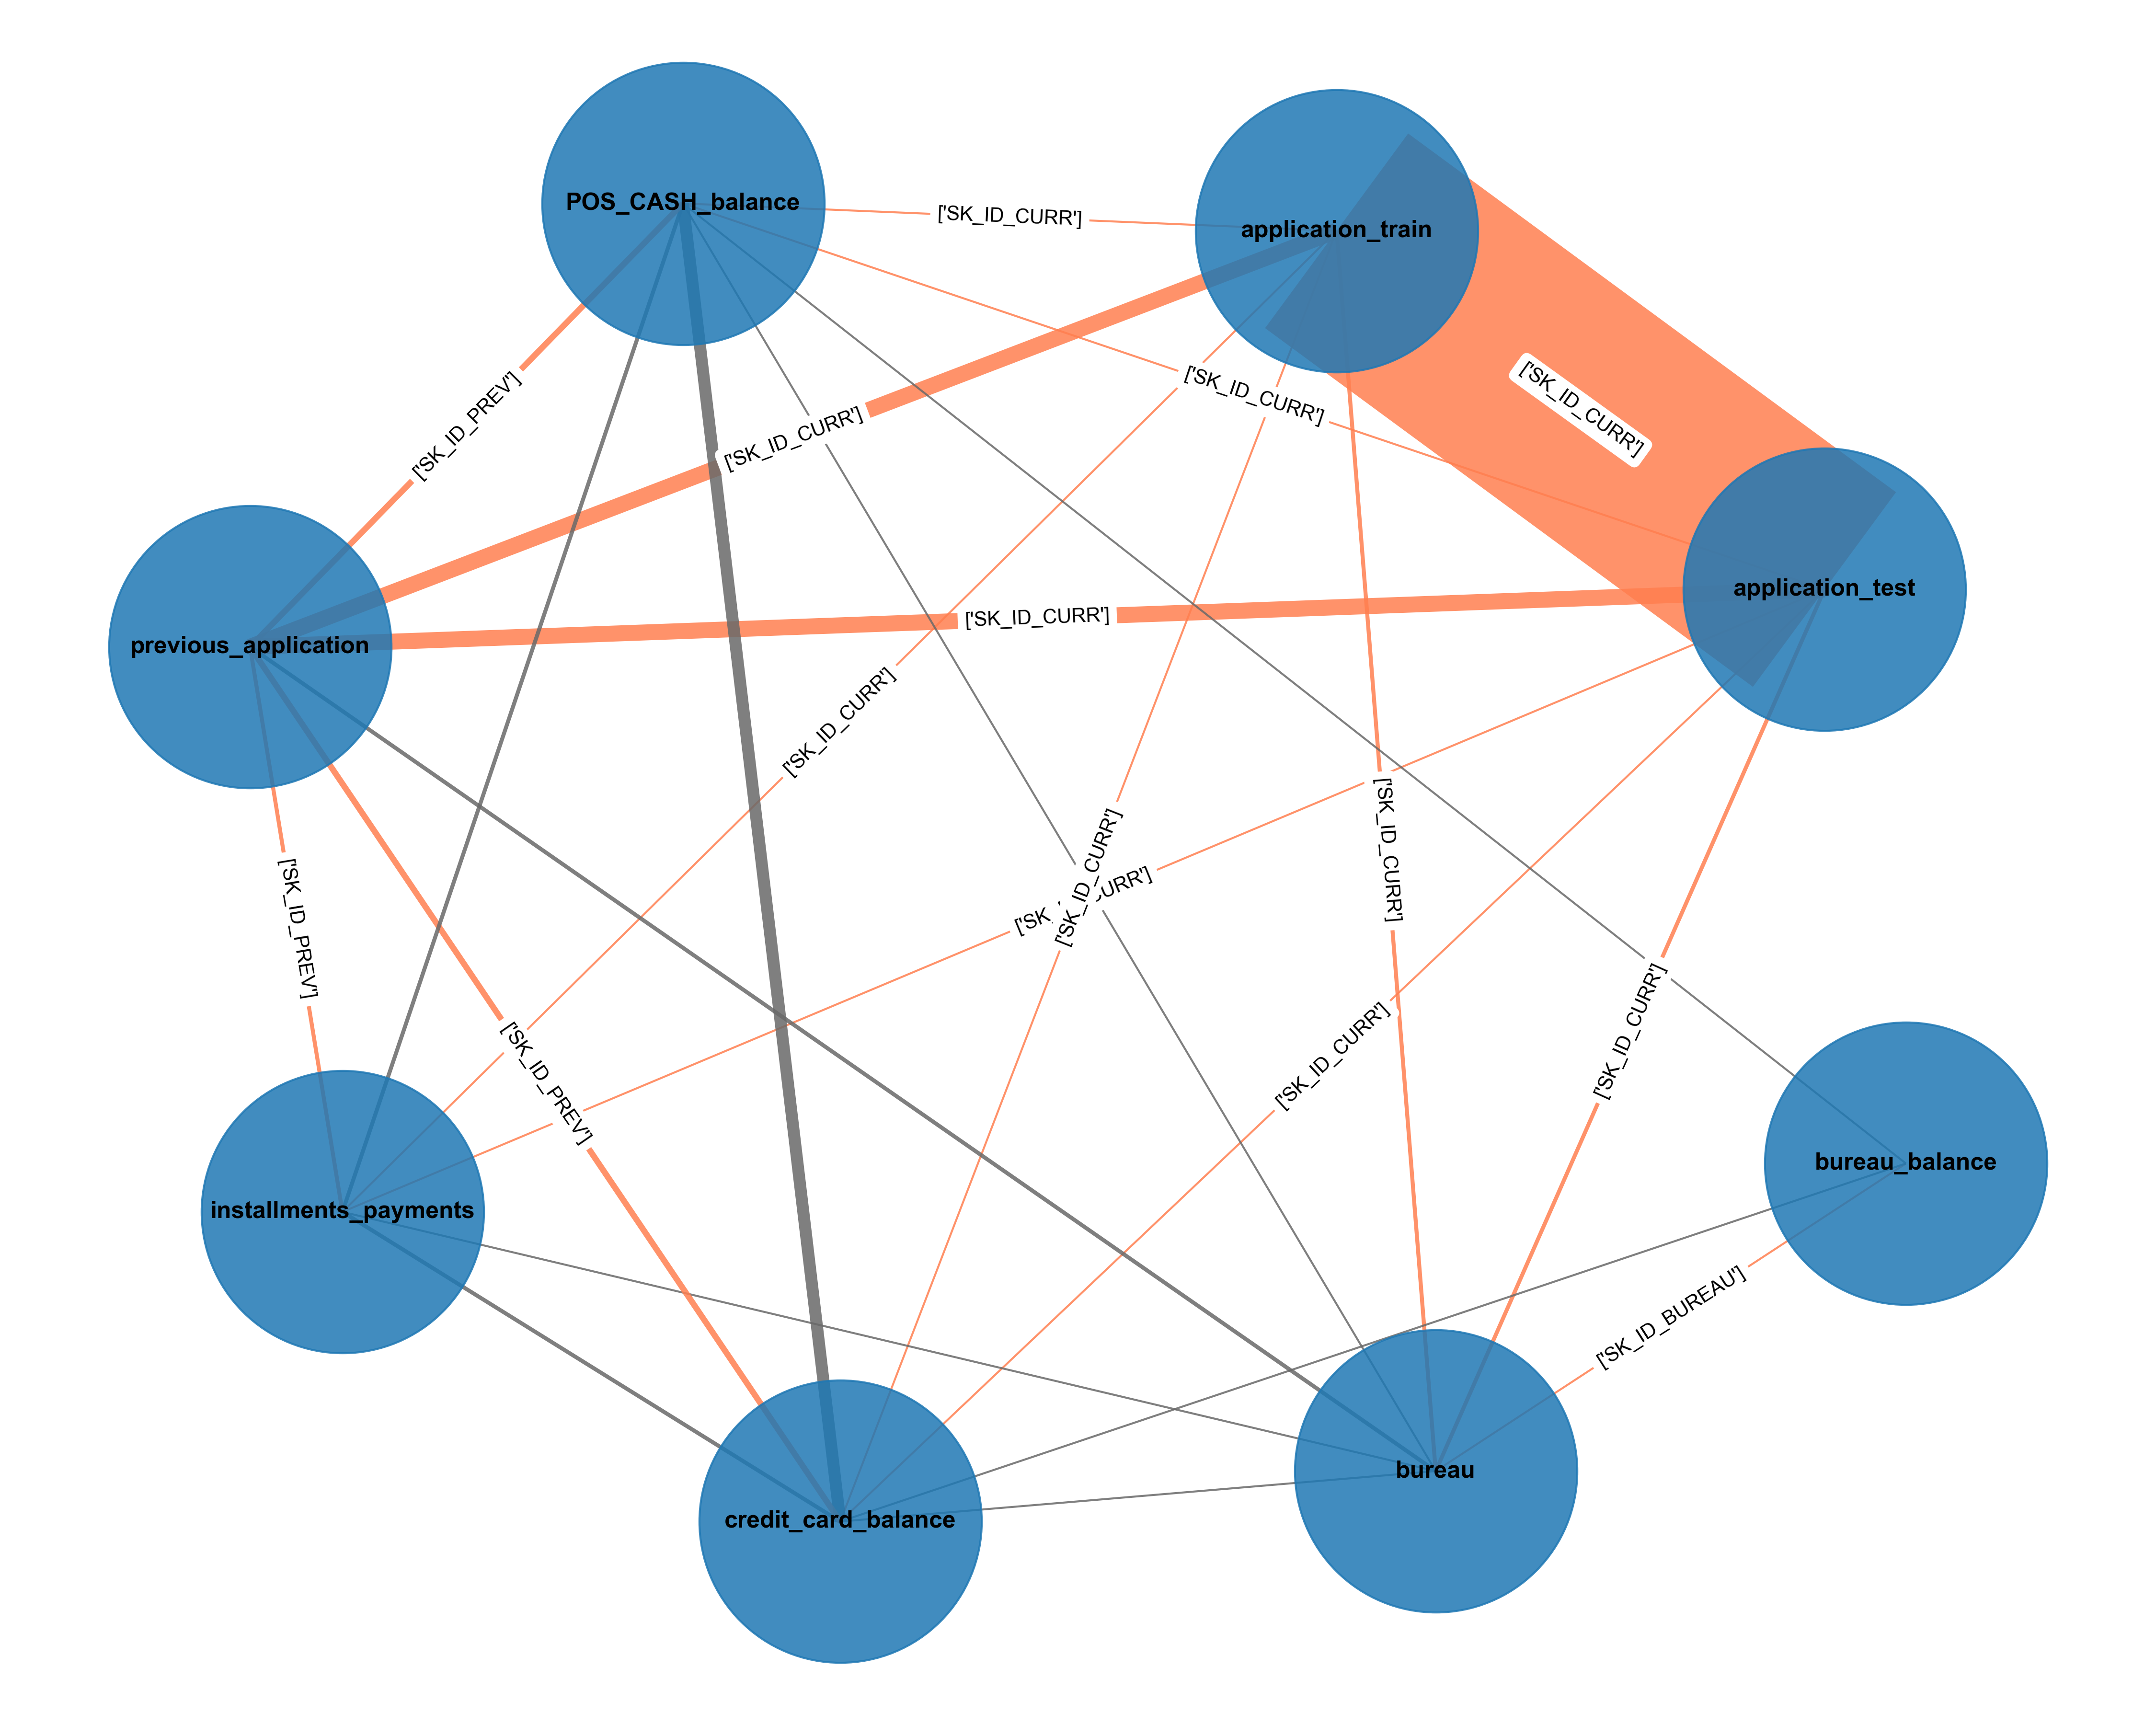

In [5]:
# Graphe des relations entre les fichiers du jeu de données
run_dataset_graph = False # Effectue le calcul si True sinon affiche le fichier
print(Fore.BLACK + Style.BRIGHT + Back.WHITE
      + f"Graphe des relations entre les fichiers du jeu de données:\n"
      + Style.RESET_ALL)
if run_dataset_graph:
    dataset_graph(df_nrel, df_feat, df_keynrel, df_keyfeat, max_eli=2, save="dataset_graph.png")
else:
    display_png(Image(fig_path + "dataset_graph.png"))

# Nettoyage des données
    del df_nrel, df_feat, df_keynrel, df_keyfeat
    gc.collect()

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="dataset_org"></a>
### 2.5 - Organisation du jeu de données présenté par Kaggle
Le graphe ci-après donne l'organisation des fichiers de données tel que présenté par Kaggle.
On notera en particulier la cohérence entre le graphe précédent et cette représentation.

Organisation du jeu de données présenté sur le site de Kaggle:



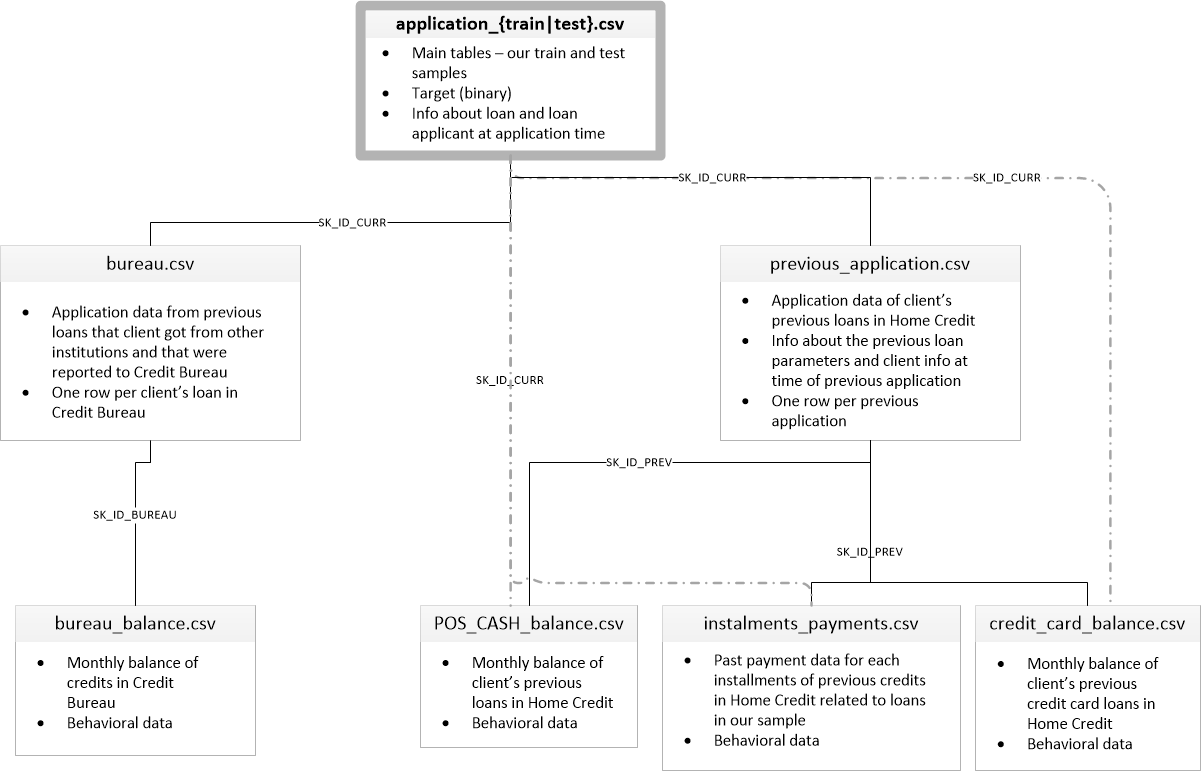

In [6]:
print(Fore.BLACK + Style.BRIGHT + Back.WHITE
      + f"Organisation du jeu de données présenté sur le site de Kaggle:\n"
      + Style.RESET_ALL)
display_png(Image(input_data_path+"home_credit.png"))

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="dataset_keys"></a>
### 2.6 - Éléments de compréhension du jeu de données
La prédiction recherchée correspond à la variable 'TARGET', présente dans le fichier de données 'application_train'. Selon le fichier 'HomeCredit_columns_description', cette variable binaire indique si le client est à risque pour le remboursement du prêt:
- 1: client avec des difficultés de paiement, classe minoritaire ;
- 0: autre (pas de difficulté de paiement anticipée), classe majoritaire.

La population totale (entrainement + test) est de 356255, dont 86.3% pour l'entrainement et 13.7% pour le test.

Les clients sont identifiés par la variable 'SK_ID_CURR', présente dans 6 des 7 fichiers de données ('application_train', 'bureau', 'credit_card_balance', 'installments_payments', 'POS_CASH_balance', 'previous_application'), constituant la variable charnière d'agrégation de ces fichiers à partir du fichier 'application_train' dont elle est la feature-clé.

Le fichier non relié par cette variable est 'bureau_balance', qui partage la feature 'SK_ID_BUREAU' avec le fichier 'bureau', qui code de manière unique chaque demande de prêt passée auprès d'un autre établissement financier et permet d'agréger le fichier 'bureau_balance' au fichier 'bureau' (feature-clé du fichier 'bureau').

Les autres informations clés des différents fichiers :
- Les fichiers 'bureau' et 'bureau_balance' concernent les précédents prêts contractés auprès d'autres établissements financiers.
- Fichier 'bureau_balance': la feature 'STATUS' indique, lorsqu'il s'agit d'un chiffre, les éventuels retards de paiement en nombre de mois, en correspondance avec le mois concerné du crédit ('MONTHS_BALANCE').
- Les fichiers 'previous_application', 'POS_CASH_balance', 'installments_payments' et 'credit_card_balance' concernent les précédents prêts contractés auprès de l'établissement financier.
- Le fichier 'POS_CASH_balance' donne l'instruction des précédentes demandes de prêt avec notamment les informations:
  - 'NAME_CONTRACT_STATUS': indique l'acceptation ou rejet ou annulation de la demande de prêt ;
  - 'CODE_REJECT__REASON' : le code de rejet éventuel ;
  - 'NAME_CLIENT_TYPE': indique si le client était nouveau au moment de sa précédente demande de prêt ;
  - 'NFLAG_INSURED_ON_APPROVAL': indique si le client a demandé une assurance .
- Le fichier 'credit_card_balance' indique les prêts précédents (en cours ou terminés) sur carte de crédit et 'SK_DPD' et donne en particulier les jours de retard de remboursement (Days Past Due).

In [7]:
# Fichiers de données contenant les features spécifiques de la liste list_features
list_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'MONTHS_BALANCE']
print(Fore.BLACK + Style.BRIGHT + Back.WHITE
      + f"Fichiers contenant des features spécifiques:\n"
      + Style.RESET_ALL)
for feature in list_features:
    print(f"→ {feature}:", ', '.join(features_dict[feature]))

# Dimensions des fichiers de données
print('\n')
print(Fore.BLACK + Style.BRIGHT + Back.WHITE
      + f"Dimensions et features-clés des fichiers de données:\n"
      + Style.RESET_ALL)
data_dimensions, key_features = get_dataset_info()
for f_name in filenames:
    print(f"→ {f_name}:", data_dimensions[f_name], key_features[f_name])

# Nettoyage des données
del features_dict, list_features, data_dimensions, key_features, f_name, filenames
gc.collect()

Fichiers contenant des features spécifiques:

→ TARGET: application_train
→ SK_ID_CURR: application_test, application_train, bureau, credit_card_balance, installments_payments, POS_CASH_balance, previous_application
→ SK_ID_BUREAU: bureau, bureau_balance
→ MONTHS_BALANCE: bureau_balance, credit_card_balance, POS_CASH_balance


Dimensions et features-clés des fichiers de données:

→ application_test: (48744, 121) ['SK_ID_CURR']
→ application_train: (307511, 122) ['SK_ID_CURR']
→ bureau: (1716428, 17) ['SK_ID_BUREAU']
→ bureau_balance: (27299925, 3) []
→ credit_card_balance: (3840312, 23) []
→ installments_payments: (13605401, 8) []
→ POS_CASH_balance: (10001358, 8) []
→ previous_application: (1670214, 37) ['SK_ID_PREV']


0

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="preprocessing"></a>
# 3 - Preprocessing des données
Le preprocessing des données consiste à:
- constituer le jeu de données à partir des fichiers de données, en effectuant du feature engineering pour créer de nouvelles features pertinentes ;
- traiter les valeurs manquantes et les valeurs infinies pour disposer de données compatibles avec tous les modèles de machine learning ;
- vérifier la pertinence du preprocessing.

Les 2 jeux de données, avec et sans traitement des valeurs manquantes et valeurs infinies, sont sauvegardés.

<a id="pp_aguiar"></a>
## 3.1 - Constitution du jeu de données

La constitution du jeu de données et la création de nouvelles features est importé du [preprocessing d'Aguiar](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script).

On notera en particulier:
- La création de nouvelles features par leur combinaison, en particulier avec un quotient (performance) ou une différence.
- La création systématique de nouvelles features lors des agrégations, en utilisant les fonctions 'min', max', 'mean', 'sum', 'var' et 'size'.
- Le taux relativement faible de la classe positive ('TARGET' = 1): 8.07%, montrant des classes déséquilibrées, à prendre en considération lors de la modélisation.
- Un nombre significatif de NaN et quelques valeurs infinies, à traiter ou gérer par l'algorithme de machine learning.

In [8]:
# Constitution du jeu de données et preprocessing
run_preprocessing = False # Saute cette étape si False

if run_preprocessing:
    from P7_preprocessing import *
    debug = False
    num_rows = 10000 if debug else None # 10000 est le nombre minimum pour LightGBM

    print(Fore.BLACK + Style.BRIGHT + Back.WHITE + f"application_train_test:\n" + Style.RESET_ALL)
    with timer("Preprocessing application_train_test"):
        df = application_train_test(num_rows)
        print("Dataframe shape:", df.shape)

    print(Fore.BLACK + Style.BRIGHT + Back.WHITE + f"bureau and bureau_balance:\n" + Style.RESET_ALL)
    with timer("Preprocessing bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Dataframe shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()

    print(Fore.BLACK + Style.BRIGHT + Back.WHITE + f"previous_applications:\n" + Style.RESET_ALL)
    with timer("Preprocessing previous_applications"):
        prev = previous_application(num_rows)
        print("Dataframe shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()

    print(Fore.BLACK + Style.BRIGHT + Back.WHITE + f"POS-CASH balance:\n" + Style.RESET_ALL)
    with timer("Preprocessing POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Dataframe shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()

    print(Fore.BLACK + Style.BRIGHT + Back.WHITE + f"installments payments:\n" + Style.RESET_ALL)
    with timer("Preprocessing installments payments"):
        ins = installments_payments(num_rows)
        print("Dataframe shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()

    print(Fore.BLACK + Style.BRIGHT + Back.WHITE + f"credit card balance:\n" + Style.RESET_ALL)
    with timer("Preprocessing credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Dataframe shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    print(Fore.BLACK + Style.BRIGHT + Back.WHITE + f"Données preprocessed:\n" + Style.RESET_ALL)
    print(f"Dimensions du jeu de données assemblé (P7_data_preprocessed.csv): {df.shape}"
          f", dont {len(df.loc[~df['TARGET'].isnull(), 'TARGET'])} données d'entrainement"
          f" et {len(df.loc[df['TARGET'].isnull(), 'TARGET'])} données de test")
    display(pd.concat([df.head(2), df.tail(2)], axis=0))
    df.to_csv(data_path + 'P7_data_preprocessed.csv', sep=';', index=False)

    # Vérification des valeurs infinies et valeurs manquantes
    df = check_for_inf(df)
    if get_df_nan_rate(df)>0:
        # '*_pattern_list' sont définis dans le module 'P7_preprocessing'
        df_nan = features_with_nan(df, num_pattern_list=num_pattern_list, cat_pattern_list=cat_pattern_list)
        df_nan.to_csv(data_path + 'P7_data_nan.csv', sep=';', index=False)
else:
    df = pd.read_csv(data_path + 'P7_data_preprocessed.csv', sep=';')
    print(Fore.BLACK + Style.BRIGHT + Back.WHITE + f"Assemblage du jeu de données:\n" + Style.RESET_ALL)
    print(f"Dimensions du jeu de données assemblé (P7_data_preprocessed.csv): {df.shape}"
          f", dont {len(df.loc[~df['TARGET'].isnull(), 'TARGET'])} données d'entrainement"
          f" et {len(df.loc[df['TARGET'].isnull(), 'TARGET'])} données de test")
    display(pd.concat([df.head(2), df.tail(2)], axis=0))
    df_nan = pd.read_csv(data_path + 'P7_data_nan.csv', sep=';')
    print("Caractérisation des features contenant des valeurs manquantes:")
    display(df_nan.head())

Assemblage du jeu de données:

Dimensions du jeu de données assemblé (P7_data_preprocessed.csv): (356251, 797), dont 307507 données d'entrainement et 48744 données de test


SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  ELEVATORS_MODE  \
0         100002      1.0        0             0              0               0           202500.0       4.066e+05    24700.5       3.510e+05                0.019               -9461       -637.0          -3648.0            -2120            NaN           1             1               0                 1              1           0            1.0                  2                        2                         10                          0                           0                           0                          0                       0                       0                 0.083         0.263         0.139          0.025            0.037                  0.972                  0.619            0.014          0.00           0.069          0.083          0.125          0.037             0.020              0.019               0.000                 0.000             0.025             0.038                    0.972                   0.634            0.014            0.000       
1         100003      0.0        1             0              1               0           270000.0       1.294e+06    35698.5       1.130e+06                0.004              -16765      -1188.0          -1186.0             -291            NaN           1             1               0                 1              1           0            2.0                  1                        1                         11                          0                           0                           0                          0                       0                       0                 0.311         0.622           NaN          0.096            0.053                  0.985                  0.796            0.060          0.08           0.035          0.292          0.333          0.013             0.077              0.055               0.004                 0.010             0.092             0.054                    0.985                   0.804            0.050            0.081       
356249    456224      NaN        0             0              1               0           225000.0       4.500e+05    25128.0       4.500e+05                0.019              -13968      -2731.0          -1461.0            -1364            NaN           1             1               1                 1              1           0            2.0                  2                        2                         10                          0                           1                           1                          0                       1                       1                 0.373         0.446         0.595          0.163            0.072                  0.990                    NaN              NaN          0.16           0.069          0.625            NaN            NaN               NaN              0.156                 NaN                 0.149             0.166             0.075                    0.990                     NaN              NaN            0.161       
3562

Caractérisation des features contenant des valeurs manquantes:


feature       nan_nb nan_rate nan_minclass_rate     type      nunique  unique  recommended_strategy
0           TARGET   48744   13.7%         0.00%       cat_bin_num       2   [1. 0.]   NaN as a category 
1      AMT_ANNUITY      36    0.0%         0.00%               num   14166       inf              median 
2  AMT_GOODS_PRICE     278    0.1%         7.55%               num    1291       inf              median 
3    DAYS_EMPLOYED   64648   18.1%         4.63%               num   12895       inf              median 
4      OWN_CAR_AGE  235239   66.0%         7.33%               num      63       inf       most_frequent

In [9]:
# Colonnes numériques et catégorielles
run_columns = False # Saute cette étape si False
print(Fore.BLACK + Style.BRIGHT + Back.WHITE +
      f"Vérifications des colonnes numériques et catégorielles de "
      f"'df' en cohérence avec 'df_nan':\n"
      + Style.RESET_ALL)

if run_columns:
    # Vérifications des colonnes numériques et catégorielles en cohérence avec df_nan
    categorical_columns, numerical_columns = get_var()
    print("DataSet (df) shape:", df.shape)
    print(" → dont colonnes catégorielles:", len(categorical_columns))
    print(" → dont colonnes numériques:", len(numerical_columns))

    print("\nFeatures numériques:")
    nan_num_feat = df_nan.loc[df_nan['type']=='num', 'feature'].tolist()
    print("→ Nombre de features numériques dans df_nan:", len(nan_num_feat))
    print("→ Nombre de features numériques qui ne sont pas dans df_nan:", len([f for f in numerical_columns if f not in nan_num_feat]))
    print("→ Nombre de features numériques de df sans NaN:", df.shape[1] - df.isnull().any().sum() - (len(categorical_columns)-1)) # 'TARGET' contient des NaN
    print("→ Nombre de features numériques de df_nan qui ne sont pas dans les features numériques", len([f for f in nan_num_feat if f not in numerical_columns]))
    mask = np.array(df.isnull().any().tolist(), dtype=bool)
    df_columns_wo_nan = np.array(df.columns.tolist())
    df_num_columns_wo_nan = [f for f in df_columns_wo_nan[~mask] if f in numerical_columns]
    feat = list(set([f for f in numerical_columns if f not in nan_num_feat]) - set(df_num_columns_wo_nan))
    print("→ Features numériques qui ne sont pas dans df_nan - features de df sans NaN:", len(feat), feat)
    print("\nFeatures catégorielles:")
    nan_cat_feat = df_nan.loc[df_nan['type']!='num', 'feature'].tolist()
    print(" → Features catégorielles dans df_nan:", len(nan_cat_feat), nan_cat_feat, '\n')

    # Sauvegarde des listes de colonnes numériques / catégorielles dans des fichiers
    print(Fore.BLACK + Style.BRIGHT + Back.WHITE + f"Sauvegarde des listes des colonnes numériques et catégorielles :\n" + Style.RESET_ALL)

    num_filename = data_path + 'P7_num_features.txt'
    with open(num_filename, "w") as file:
        print(f"Sauvegarde de la liste des features numériques dans {num_filename}")
        json.dump(numerical_columns, file)
    with open(num_filename, "r") as file:
        l = json.load(file)
    print(f"Vérification de lecture de {num_filename}: {len(l)} éléments, type={type(l)}, liste={', '.join(l[:2])}...\n")

    cat_filename = data_path + 'P7_cat_features.txt'
    with open(cat_filename, "w") as file:
        print(f"Sauvegarde de la liste des features catégorielles dans {cat_filename}")
        json.dump(categorical_columns, file)
    with open(cat_filename, "r") as file:
        l = json.load(file)
    print(f"Vérification de lecture de {cat_filename}: {len(l)} éléments, type={type(l)}, liste={', '.join(l[:2])}...")

    del l
    gc.collect()

else:
    # Liste des colonnes de données numériques sauvegardées
    non_input_features_list = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
    with open(data_path + 'P7_num_features.txt', "r") as file:
        numerical_columns = json.load(file)
    numerical_columns = [f for f in numerical_columns if f not in non_input_features_list]
    print(f"→ {len(numerical_columns)} colonnes numériques")
    #
    with open(data_path + 'P7_cat_features.txt', "r") as file:
        categorical_columns = json.load(file)
    categorical_columns = [f for f in categorical_columns if f not in non_input_features_list]
    print(f"→ {len(categorical_columns)} colonnes catégorielles hors 'TARGET'")

Vérifications des colonnes numériques et catégorielles de 'df' en cohérence avec 'df_nan':

→ 627 colonnes numériques
→ 168 colonnes catégorielles hors 'TARGET'


[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="pp_nan"></a>
## 3.2 - Traitement des valeurs manquantes
Les valeurs manquantes sont traitées en priorité par décision spécifique de traitement (affectation d'une valeur ou suppression de l'échantillon) ou par défaut par application de la stratégie recommandée (valeur moyenne, valeur médiane ou valeur la plus fréquente).
À noter que toutes les variables catégorielles (à l'exception de la sortie 'TARGET') ont été encodées avec la fonction 'one_hot_encoder' du module 'P7_functions', en considérant les valeurs manquantes comme une modalité catégorielle (une colonne 'NaN' est ajoutée comme catégorie de chaque feature ayant des valeurs manquantes).

In [10]:
# Diagnostic des actions pour traiter les valeurs manquantes
run_nan_diag = False # Saute cette étape si False
print(Fore.BLACK + Style.BRIGHT + Back.WHITE +
      f"Classement des features par ordre décroissant d'importance:\n"
      + Style.RESET_ALL)

if run_nan_diag:
    # Classement des features par ordre décroissant d'importance - source lightGBM kernel Aguiar
    df_nan = pd.read_csv(data_path + 'P7_data_nan.csv', sep=';', index_col='feature')

    # Importance des features issue du modèle
    df_featImp = pd.read_csv(data_path + 'P7_kernel_LightGBM_featImp.csv', sep=';')
    df_tmp = df_featImp[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)

    # Création des features 'importance' et 'cum_importance_pc' dans df_nan et tri
    df_nan['importance'] = df_tmp['importance'].copy()
    df_nan = df_nan.sort_values(by="importance", ascending=False).reset_index().fillna(value=0)
    df_nan['cum_importance_pc'] = 100.0 * df_nan['importance'].cumsum() / df_nan['importance'].sum()

    # Affichage et sauvegarde
    df_nan['cum_importance_pc'] = df_nan['cum_importance_pc'].map('{:.2f}%'.format)
    display(df_nan.head())
    df_nan.to_csv(data_path + 'P7_data_nan.csv', sep=';', index=False)

    # Nettoyage des données
    del df_featImp, df_tmp
    gc.collect()

else:
    df_nan = pd.read_csv(data_path + 'P7_data_nan.csv', sep=';')
    display(df_nan.head())

Classement des features par ordre décroissant d'importance:



feature       nan_nb nan_rate nan_minclass_rate     type      nunique  unique  recommended_strategy
0           TARGET   48744   13.7%         0.00%       cat_bin_num       2   [1. 0.]   NaN as a category 
1      AMT_ANNUITY      36    0.0%         0.00%               num   14166       inf              median 
2  AMT_GOODS_PRICE     278    0.1%         7.55%               num    1291       inf              median 
3    DAYS_EMPLOYED   64648   18.1%         4.63%               num   12895       inf              median 
4      OWN_CAR_AGE  235239   66.0%         7.33%               num      63       inf       most_frequent

In [11]:
# Dictionnaire des décisions de traitement des manquants (à la place de la stratégie recommandée de df_nan)
run_nan_decisions = False # Saute cette étape si False
print(Fore.BLACK + Style.BRIGHT + Back.WHITE +
      f"Décisions de traitement des valeurs manquantes:\n"
      + Style.RESET_ALL)

if run_nan_decisions:
    nan_decisions = {#'PAYMENT_RATE': 'drop', # idem 'AMT_ANNUITY'
                     #'AMT_ANNUITY': 'drop', # 36 manquants uniquement sur classe majoritaire
                     'DAYS_EMPLOYED': 'median', # personnes à la retraite
                     'DAYS_EMPLOYED_PERC': 'max', # personnes à la retraite 'DAYS_EMPLOYED' / 'DAYS_BIRTH'
                     #'ANNUITY_INCOME_PERC': 'drop', # idem 'AMT_ANNUITY'
                     '#ACTIVE_': 0, # nan des variables contenant 'ACTIVE_'
                     '#BURO_': 0, # nan des variables contenant 'BURO_'
                     '#CLOSED_': 0, # nan des variables contenant 'CLOSED_'
                     #'DAYS_LAST_PHONE_CHANGE': 'drop', # 1 manquant uniquement sur classe majoritaire
                     'OWN_CAR_AGE': 0, # pas de voiture: 0 (neuve=forte valeur, faible coût) ou max (âgée=faible valeur, coût élevé)?
                     '#APPROVED_AMT_': 0, # nan des variables contenant 'APPROVED_AMT_': montants demandés et acceptés
                     '#APP_CREDIT_PERC': 1, # nan des variables contenant 'APPROVED_APP_CREDIT_PERC': 'AMT_APPLICATION' / 'AMT_CREDIT'
                     '#DAYS_CREDIT_UPDATE': 'mean', # nan des variables contenant 'DAYS_CREDIT_UPDATE'
                     '#DAYS_': 'min', # nan des variables contenant 'DAYS_' (sauf elles ci-dessus)
                     '#MONTHS_BALANCE': 0, # nan des variables contenant 'MONTHS_BALANCE'
                     '#PAYMENT_PERC': 1, # nan des variables contenant 'PAYMENT_PERC': 'AMT_PAYMENT' / 'AMT_INSTALMENT'
                     '#PAYMENT_DIFF': 0, # nan des variables contenant 'PAYMENT_DIFF': 'AMT_INSTALMENT' - 'AMT_PAYMENT'
                     '#CNT_PAYMENT': 0, # nan des variables contenant 'CNT_PAYMENT'
                     '#_DPD': 0, # nan des variables contenant '_DPD'
                     '#AMT_PAYMENT': 0, # nan des variables contenant 'AMT_PAYMENT'
                     '#PREV_AMT_GOODS_PRICE': 0, # nan des variables contenant 'PREV_AMT_GOODS_PRICE'
                     '#APPROVED_AMT_GOODS_PRICE': 0, # nan des variables contenant 'APPROVED_AMT_GOODS_PRICE'
                     '#REFUSED_AMT_GOODS_PRICE': 0, # nan des variables contenant 'REFUSED_AMT_GOODS_PRICE'
                     #'INCOME_PER_PERSON': 'drop', # 2 manquants uniquement sur classe majoritaire
                     #'CNT_FAM_MEMBERS': 'drop', # 2 manquants uniquement sur classe majoritaire
                     }
    df_nan = pd.read_csv(data_path + 'P7_data_nan.csv', sep=';')
    df_nan = nan_treament_decisions(df_nan, nan_decisions=nan_decisions, save=data_path + 'P7_data_nan.csv')
    display(df_nan.head())

else:
    df_nan = pd.read_csv(data_path + 'P7_data_nan.csv', sep=';')
    display(df_nan.head())

Décisions de traitement des valeurs manquantes:



feature       nan_nb nan_rate nan_minclass_rate     type      nunique  unique  recommended_strategy
0           TARGET   48744   13.7%         0.00%       cat_bin_num       2   [1. 0.]   NaN as a category 
1      AMT_ANNUITY      36    0.0%         0.00%               num   14166       inf              median 
2  AMT_GOODS_PRICE     278    0.1%         7.55%               num    1291       inf              median 
3    DAYS_EMPLOYED   64648   18.1%         4.63%               num   12895       inf              median 
4      OWN_CAR_AGE  235239   66.0%         7.33%               num      63       inf       most_frequent

In [12]:
# Traitement automatique des valeurs manquantes
run_nan_treatment = False # Saute cette étape si False
print(Fore.BLACK + Style.BRIGHT + Back.WHITE +
          f"Traitement automatique des valeurs manquantes:\n"
          + Style.RESET_ALL)

if run_nan_treatment:
    # Traitement des valeurs manquantes
    df_auto = nan_treatment(df, df_nan, mode='auto', save=data_path+'P7_data_preprocessed_woNaN_auto.csv')

    # Vérification de l'état des manquants et dimensions
    if get_df_nan_rate(df_auto)>0:
        # '*_pattern_list' sont définis dans le module 'P7_preprocessing'
        features_with_nan(df_auto, num_pattern_list=num_pattern_list, cat_pattern_list=cat_pattern_list)
    print(f"Dimensions du jeu de données assemblé ('P7_data_preprocessed_woNaN.csv')"
          f" après traitement des valeurs manquantes: {df_auto.shape}"
          f", dont {len(df_auto.loc[~df_auto['TARGET'].isnull(), 'TARGET'])} données d'entrainement"
          f" et {len(df_auto.loc[df_auto['TARGET'].isnull(), 'TARGET'])} données de test")

    # Nettoyage des données
    del df_auto
    gc.collect()

else:
    df_auto = pd.read_csv(data_path + 'P7_data_preprocessed_woNaN_auto.csv', sep=';')
    check_for_inf(df_auto, replace_with_nan=False, verbose=True)
    get_df_nan_rate(df_auto.loc[~df_auto['TARGET'].isnull()], verbose=True)
    print(f"Dimensions du jeu de données assemblé ('P7_data_preprocessed_woNaN_auto.csv')"
          f" après traitement des valeurs manquantes: {df_auto.shape}"
          f", dont {len(df_auto.loc[~df_auto['TARGET'].isnull(), 'TARGET'])} données d'entrainement"
          f" et {len(df_auto.loc[df_auto['TARGET'].isnull(), 'TARGET'])} données de test")

    # Nettoyage des données
    del df_auto, df_nan
    gc.collect()

Traitement automatique des valeurs manquantes:

Les données ne contiennent pas de valeur infinie
Taux de NaN: 0.00%
Dimensions du jeu de données assemblé ('P7_data_preprocessed_woNaN_auto.csv') après traitement des valeurs manquantes: (356251, 797), dont 307507 données d'entrainement et 48744 données de test


In [13]:
# Traitement avec décisions spécifiques des valeurs manquantes
run_nan_treatment = False # Saute cette étape si False
print(Fore.BLACK + Style.BRIGHT + Back.WHITE +
          f"Traitement des valeurs manquantes avec des décisions spécifiques:\n"
          + Style.RESET_ALL)

if run_nan_treatment:
    # Traitement des valeurs manquantes
    df_forced = nan_treatment(df, df_nan, mode='forced', save=data_path+'P7_data_preprocessed_woNaN_forced.csv')

    # Vérification de l'état des manquants et dimensions
    if get_df_nan_rate(df_forced)>0:
        # '*_pattern_list' sont définis dans le module 'P7_preprocessing'
        features_with_nan(df_forced, num_pattern_list=num_pattern_list, cat_pattern_list=cat_pattern_list)
    print(f"Dimensions du jeu de données assemblé ('P7_data_preprocessed_woNaN_forced.csv')"
          f" après traitement des valeurs manquantes: {df_forced.shape}"
          f", dont {len(df_forced.loc[~df_forced['TARGET'].isnull(), 'TARGET'])} données d'entrainement"
          f" et {len(df_forced.loc[df_forced['TARGET'].isnull(), 'TARGET'])} données de test")

    # Nettoyage des données
    del df_forced
    gc.collect()

else:
    df_forced = pd.read_csv(data_path + 'P7_data_preprocessed_woNaN_forced.csv', sep=';')
    check_for_inf(df_forced, replace_with_nan=False, verbose=True)
    get_df_nan_rate(df_forced.loc[~df_forced['TARGET'].isnull()], verbose=True)
    print(f"Dimensions du jeu de données assemblé ('P7_data_preprocessed_woNaN_forced.csv')"
          f" après traitement des valeurs manquantes: {df_forced.shape}"
          f", dont {len(df_forced.loc[~df_forced['TARGET'].isnull(), 'TARGET'])} données d'entrainement"
          f" et {len(df_forced.loc[df_forced['TARGET'].isnull(), 'TARGET'])} données de test")

    # Nettoyage des données
    del df_forced
    gc.collect()

Traitement des valeurs manquantes avec des décisions spécifiques:

Les données ne contiennent pas de valeur infinie
Taux de NaN: 0.00%
Dimensions du jeu de données assemblé ('P7_data_preprocessed_woNaN_forced.csv') après traitement des valeurs manquantes: (356251, 797), dont 307507 données d'entrainement et 48744 données de test


[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="lgbm_aguiar"></a>
## 3.3 - Vérification du preprocessing avec la modélisation LightGBM d'Aguiar
Cette modélisation s'appuie sur le [kernel LightGBM de Tilii](https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code) et la [modélisation d'Aguiar](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script).

Nous allons l'utiliser sur les 2 jeux de données avec et sans traitement des valeurs manquantes afin de vérifier l'effet du traitement des manquants sur la modélisation.
Cette modélisation utilise l'AUROC (Aire de la courbe ROC) comme métrique d'optimisation du modèle et renvoie les probabilités de classe pour le jeu de test. À partir de ces probabilités, la courbe ROC est utilisée pour optimiser le seuil entre les classes 0 et 1. Dans cette approche, il correspond au point de la courbe ROC le plus proche d'un recall=1 et specificity=1.
Nous allons également comptabiliser le temps d'entrainement.



<a id="lgbm_aguiar_withNaN"></a>
### 3.3.1 - LightGBM sans prétraitement des manquants
Dans cette version, les manquants sont des valeurs numériques (les catégorielles sont déjà gérées) et sont gérés par LightGBM (LIGHTGBM ignore les valeurs manquantes lors du découpage du jeu, puis les alloue au côté qui réduit le plus la perte).


In [14]:
run_lgbm = False # Saute cette étape si False

if run_lgbm:
    from P7_ml_lgbm import *
    debug = False
    fromfile = True
    filename = data_path + 'P7_data_preprocessed.csv' if not debug and fromfile else None
    if not debug and fromfile: df = None
    feat_importance = kfold_lightgbm_auc(df, num_folds=10, stratified=False, alpha=1.0, debug=debug, df_fromfile=filename)
    if fromfile:
        del df
        gc.collect()

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="lgbm_aguiar_w0NaN_auto"></a>
### 3.3.2 - LightGBM avec traitement préalable des manquants en mode automatique

In [15]:
run_lgbm = False # Saute cette étape si False

if run_lgbm:
    from P7_ml_lgbm import *
    fromfile = True
    debug = False
    filename = data_path + 'P7_data_preprocessed_woNaN_auto.csv' if not debug and fromfile else None
    if not debug and fromfile: df = None
    feat_importance = kfold_lightgbm_auc(df, num_folds=10, stratified=False, alpha=1.0, debug=debug, df_fromfile=filename)
    if fromfile:
        del df
        gc.collect()

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="lgbm_aguiar_w0NaN_forced"></a>
### 3.3.3 - LightGBM avec traitement préalable des manquants à partir de décisions spécifiques

In [16]:
run_lgbm = False # Saute cette étape si False

if run_lgbm:
    from P7_ml_lgbm import *
    fromfile = True
    debug = False
    filename = data_path + 'P7_data_preprocessed_woNaN_forced.csv' if not debug and fromfile else None
    if not debug and fromfile: df = None
    feat_importance = kfold_lightgbm_auc(df, num_folds=10, stratified=False, alpha=1.0, debug=debug, df_fromfile=filename)
    if fromfile:
        del df
        gc.collect()

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="pp_conclusion"></a>
## 3.4 - Conclusion sur le preprocessing
Le bon niveau de score donne confiance dans le preprocessing d'Aguiar que nous retenons.

Le traitement des valeurs manquantes est conforté par un score (en terme d'AUROC) identique pour les 2 approches (avec et sans prétraitement des NaN).
Par ailleurs, on notera un gain de temps de 25 à 30% lorsque les valeurs manquantes sont prétraitées.

Enfin, le calcul du seuil optimum entre les classes donne un taux de 29% pour la classe positive alors que le jeu d'entrainement n'en contient que 8%. Cela montre que la métrique AUROC n'est pas la mieux adaptée parce que les classes ne sont pas d'égale importance. En effet, le coût d'un faux positif (bon crédit considéré comme mauvais) génère un manque à gagner pour la banque, alors qu'un faux négatif (mauvais crédit considéré comme bon) génère un coût de défaut de paiement bien supérieur. Nous en tiendrons compte dans la définition des métriques à utiliser pour le machine learning.

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="model_research"></a>
# 4 - Recherche du meilleur modèle de classification

<a id="model_metrics"></a>
## 4.1 - Choix de métrique
Nous disposons d'un jeu de données déséquilibré pour lequel:
- La classe minoritaire est la classe positive (1): elle représente les clients avec des difficultés de paiement ;
- La classe majoritaire est la classe négative (0): elle représente les autres clients.

Le choix de la métrique découle de ce déséquilibre, du fait que les classes ne sont pas d'égale importance (le risque pour l'organisme financier n'est pas le même selon la classe) et du besoin de prédire les labels de classe (0 ou 1). En conséquence, la métrique est soit la 'AUPR' (aire sous la courbe precision-recall), soit le fbeta score (moyenne harmonique pondérée de precision et recall).

Dans une approche technique, nous utiliserons le 'AUPR', métrique qui utilise les prédictions des probabilités des classes. Cette métrique peut être obtenue de 2 manières avec scikit-learn:
- la métrique 'average_precision_score', qui calcule la valeur moyenne de la precision lorsque le recall varie entre 0 et 1 ;
- le calcul de l'aire de la courbe PR avec la fonction 'auc' (interpolation trapézoïdale), dont les paramètres de precision et recall sont obtenus par la fonction de calcul de la courbe PR 'precision_recall_curve'.

Les résultats de ces 2 calculs n'étant pas exactement les mêmes, les comparaisons entre modèles devront s'effectuer de la même manière.

&nbsp;
Dans une approche orientée métier, nous utiliserons le fbeta score, métrique qui utilise les prédictions des labels de classe, en utilisant la pondération beta pour se rapprocher de la préoccupation métier concernant la différence de coût entre les faux négatif (FN) et faux positif (FP). En effet, un faux positif (bon crédit considéré comme mauvais) génère un manque à gagner pour la banque (recette virtuelle non encaissée), alors qu'un faux négatif (mauvais crédit considéré comme bon) génère un coût réel de défaut de paiement.

&nbsp;
Notons que dans une approche métier concertée avec le client, nous aurions certainement fixé une métrique plus concrète correspondant aux KPI de l'organisme financier. Une telle métrique pourrait par exemple être basée sur la maximisation du gain résultant de la différence entre les recettes et les dépenses réelles directes, telle que:

| Matrice de confusion | Recettes | Dépenses |
|:-:|:-:|:-:|
|  TP | 0 | 0 |
|  FP | 0 | 0 |
|  TN | P + I | P |
|  FN | α P | P |
avec:
- P = Montant du capital du prêt
- I = Montant des intérêts du prêt
- α = taux de recouvrement moyen des prêts défaillants (α < 1)

Gains = Recettes - Dépenses = $\sum \limits _{TN}^{} \text{I}_{i} \text{ - (1-α) } \sum \limits _{FN}^{} \text{P}_{i}$

Pour tenir compte des FP et pénaliser le modèle en conséquence, il faudrait ramener ces gains au volume total de demande de prêt:

Gains% = Gains / $\sum \text{P}_{i}$

Si nous connaissons le montant des prêts (P = 'AMT_CREDIT'), nous ne connaissons en revanche pas le montant total des intérêts ('AMT_ANUITY' est le remboursement annuel et la durée des crédits n'est pas connue). Par ailleurs, il faudrait tenir compte de l'actualisation des montants en jeu et accéder pour cela à des informations complémentaires. Avec les informations disponibles, nous ne pourrions donc que faire l'approximation de considérer les intérêts que comme un pourcentage fixe du montant du prêt (I ~ t% * P).

In [17]:
# Définition des métriques et scores
from sklearn.metrics import make_scorer, precision_recall_curve, average_precision_score, auc, fbeta_score

# Métrique et score PRAUC calculé avec 'average_precision_score':  scoring=‘average_precision’
metric = 'average_precision'
def prauc_metric(y_true, y_score):
    return average_precision_score(y_true, y_score)

# Métrique et score PRAUC calculé avec 'precision_recall_curve' et 'auc'
def alt_prauc_metric(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)
    del precision, recall, thresholds
    gc.collect()
    return pr_auc
alt_prauc_prca_score = make_scorer(alt_prauc_metric, greater_is_better=True, needs_proba=True)

# Métrique et score fbeta à partir de prediction de label
def make_scorer_fbeta(beta=1):
    return make_scorer(fbeta_score, beta=beta)
fbeta2_score = make_scorer_fbeta(beta=2)

# Métrique et score fbeta à partir de prediction de probabilité
def fbeta_metric(y_true, y_score, beta=1, return_thr=False):
    """
    Calcule le fbeta score maximum à partir de la prédiction de
        probabilité de classe et beta.
    :param y_true: array, labels vrais de classe.
    :param y_score: array, probabilités de classe (par ex tq renvoyé
        par la méthode predict_proba).
    :param beta: float, compris entre 0 et +inf, coefficient beta
        du fbeta score ; beta > 1 favorise le recall (accorde plus
        d'importance aux FN) et beta < 1 favorise la precision
        (accorde plus d'importance aux FP).
    :param return_thr: bool, si le seuil optimum est également à
        retourner ; defaul=False.
    :return: float, float optionnel
        - Score, compris en 0 et 1, 'greater_is_better'.
        - Si return_thr=False, seuil compris entre à et 1 (pour
        la détermination des labels de classe).
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    fscore = ((1 + beta**2) * precision * recall) / (beta**2 * precision + recall)
    score = np.max(fscore)
    if return_thr:
        threshold = thresholds[np.argmax(fscore)]
        del precision, recall, thresholds, fscore
        gc.collect()
        return score, threshold
    else:
        del precision, recall, thresholds, fscore
        gc.collect()
        return score
# Score fbeta_metric pour beta=2
fb2_score = make_scorer(fbeta_metric, greater_is_better=True, needs_proba=True, beta=2)

# Utilisation du fbeta_metric comme paramètre 'func_metric' de LightGBM
def fb2_funcmetric(y_true, y_score):
    is_higher_better = True
    return 'fb2_score', fbeta_metric(y_true, y_score, beta=2), is_higher_better

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="model_norm"></a>
## 4.2 - Normalisation des features numériques
La normalisation est définie sur les données d'entrainement des features numériques et appliquée sur les données d'entrainement et de test de ces features.
Les paramètres des fonctions de normalisation sont enregistrés dans la table de donnée d'analyse ('P7_data_norm_*.csv') afin de pouvoir disposer de la transformation inverse (cf fonction 'df_normalization' du module 'P7_functions').

Dans un premier temps, les données d'entrainement sont notamment vérifiées en termes de:
- cohérence d'amplitude (Max-Min) pour déterminer le besoin global de mise à l'échelle,
- asymétrie individuelle pour déterminer le besoin de la compenser (skew > 1).

Les transformations de normalisation sont réalisées par la fonction 'df_normalization' du module 'P7_functions' et comprennent en séquence:
- la réduction au minimum de l'asymétrie (fonction 'skew_treatment' du module 'P7_functions'),
- la mise à l'échelle (standardisation si distribution normale ou robust scaler sinon),
- le cas échéant, la correction complémentaire d'amplitude de certaines features.

Chaque jeu de données normalisé est sauvegardé dans un fichier csv.

<a id="model_norm_auto"></a>
### 4.2.1 - Jeu de données avec nan traitées de manière auto
Ce jeu de données normalisé est sauvegardé dans le fichier 'P7_data_preprocessed_woNaN_auto.csv' du répertoire 'data_path'.

In [18]:
# Normalisation du jeu de données avec NaN traitées de manière auto
run_normalisation = False # Saute cette étape si False
print(Fore.BLACK + Style.BRIGHT + Back.WHITE +
          f"Normalisation du jeu de données avec NaN traitées de manière auto:\n"
          + Style.RESET_ALL)

if run_normalisation:
    # Liste des colonnes de données numériques
    non_input_features_list = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
    with open(data_path + 'P7_num_features.txt', "r") as file:
        numerical_columns = json.load(file)
    numerical_columns = [f for f in numerical_columns if f not in non_input_features_list]

    # Jeu de données et index des données d'entrainement
    df = pd.read_csv(data_path + 'P7_data_preprocessed_woNaN_auto.csv', sep=';')
    train_indexes = df.index[~df['TARGET'].isnull()]

    # Besoin en normalisation, normalisation et vérification
    df_norm, scaling_required = normalization_info(df.loc[train_indexes, numerical_columns],
                                                   save=data_path+'P7_data_norm_auto.csv',
                                                   verbose=False)
    print("Besoin de mise à l'échelle des données:", scaling_required)
    df = df_normalization(df, df_norm, train_indexes=train_indexes,
                          save_df=data_path+'P7_data_preprocessed_woNaN_auto_normalized.csv',
                          save_dfnorm=data_path+'P7_data_norm_auto.csv')

    # Nettoyage des données
    del df, df_norm, scaling_required
    gc.collect()

else:
    df = pd.read_csv(data_path + 'P7_data_preprocessed_woNaN_auto_normalized.csv', sep=';')
    train_indexes = df.index[~df['TARGET'].isnull()]
    df_norm, scaling_required = normalization_info(df.loc[train_indexes, numerical_columns],
                                                   verbose=False)
    print("Normalisation des données:", scaling_required)

    # Nettoyage des données
    del df, df_norm, scaling_required
    gc.collect()

Normalisation du jeu de données avec NaN traitées de manière auto:

Normalisation des données: False


<a id="model_norm_forced"></a>
### 4.2.2 - Jeu de données avec nan traitées avec décisions
Ce jeu de données normalisé est sauvegardé dans le fichier 'P7_data_preprocessed_woNaN_forced.csv' du répertoire 'data_path'.

In [19]:
# Normalisation du jeu de données avec NaN traitées sur décisions
run_normalisation = False # Saute cette étape si False
print(Fore.BLACK + Style.BRIGHT + Back.WHITE +
          f"Normalisation du jeu de données avec NaN traitées sur décisions:\n"
          + Style.RESET_ALL)

if run_normalisation:
    # Liste des colonnes de données numériques
    non_input_features_list = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
    with open(data_path + 'P7_num_features.txt', "r") as file:
        numerical_columns = json.load(file)
    numerical_columns = [f for f in numerical_columns if f not in non_input_features_list]

    # Jeu de données et index des données d'entrainement
    df = pd.read_csv(data_path + 'P7_data_preprocessed_woNaN_forced.csv', sep=';')
    train_indexes = df.index[~df['TARGET'].isnull()]

    # Besoin en normalisation, normalisation et vérification
    df_norm, scaling_required = normalization_info(df.loc[train_indexes, numerical_columns],
                                                   save=data_path+'P7_data_norm_forced.csv',
                                                   verbose=False)
    print("Besoin de mise à l'échelle des données:", scaling_required)
    df = df_normalization(df, df_norm, train_indexes=train_indexes,
                          save_df=data_path+'P7_data_preprocessed_woNaN_forced_normalized.csv',
                          save_dfnorm=data_path+'P7_data_norm_forced.csv')

    # Nettoyage des données
    del df, df_norm, scaling_required
    gc.collect()

else:
    df = pd.read_csv(data_path + 'P7_data_preprocessed_woNaN_forced_normalized.csv', sep=';')
    train_indexes = df.index[~df['TARGET'].isnull()]
    df_norm, scaling_required = normalization_info(df.loc[train_indexes, numerical_columns],
                                                   verbose=False)
    print("Normalisation des données:", scaling_required)

    # Nettoyage des données
    del df, df_norm, scaling_required
    gc.collect()

Normalisation du jeu de données avec NaN traitées sur décisions:

Normalisation des données: True


[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="model_steps"></a>
## 4.3 - Recherche du meilleur modèle
La recherche du meilleur modèle consiste à identifier, parmi une liste de modèles présélectionnés, celui dont la capacité d'apprentissage est la meilleure.
La métrique de mesure étant définie et le jeu de données étant préparé, la démarche comprend les points suivants:
1) Une baseline avec un modèle naïf: DummyClassifier(strategy='constant', constant=1)
2) Une liste de modèles cibles à comparer: LogisticRegression, RandomForestClassifier, et LGBMClassifier.
3) Une fonction d'évaluation basée sur la métrique définie (average_precision) et s'effectuant par validations croisées avec RepeatedStratifiedKFold(n_splits=5, n_repeats=3).
4) Une optimisation des hyperparamètres avec optuna, incluant 'class_weight', afin de tirer le meilleur parti de chaque modèle. Cette étape étant fortement consommatrice de temps compte tenu de la grande dimension du jeu de données, la dimension des features est réduite en utilisant un PCA avec 99% de la variance expliquée.
5) Un ré-échantillonnage éventuel pour compenser le déséquilibre des classes, faisant l'objet d'un pipeline (librairie imbalanced-learn) avec le modèle. L'éventuel ré-échantillonnage n'est exécuté que sur le jeu d'entrainement et pas sur le jeu de test.
6) La sélection du meilleur modèle sur la base de sa plage de score d'entrainement, en vérifiant en parallèle sa cohérence avec le score de test.

<a id="model_list"></a>
### 4.3.1 - Baseline et modèles cibles à tester et comparer

In [20]:
# Liste des modèles cibles à tester et comparer
import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from lightgbm import LGBMClassifier

print("Versions des librairies des modèles:")
print('- Scikit-learn : ' + sklearn.__version__)
print('- LightGBM : ' + lightgbm.__version__+ '\n')

def create_models():
    """
    Crée une liste de modèles, chacun sous forme d'un
        dictionnaire qui contiendra les informations
        qui seront produites au cours de l'évaluation.
    :return: list, liste de dictionnaires contenant:
        - 'name': acronyme du modèle
        - 'model': objet modèle
    """
    model_list = list()
    # Baseline
    dc = {'name': list(), 'model': list()}
    dc['name'] = 'DC'
    dc['model']= DummyClassifier(strategy='constant', constant=1)
    model_list.append(dc)
    # LogisticRegression
    lr = {'name': list(), 'model': list()}
    lr['name'] = 'LR'
    lr['model'] = LogisticRegression()
    model_list.append(lr)
    # RandomForestClassifier
    rf = {'name': list(), 'model': list()}
    rf['name'] = 'RF'
    rf['model'] = RandomForestClassifier()
    model_list.append(rf)
    # LGBMClassifier
    lg = {'name': list(), 'model': list()}
    lg['name'] = 'LG'
    lg['model'] = LGBMClassifier()
    model_list.append(lg)
    return model_list

print(Fore.BLACK + Style.BRIGHT + Back.WHITE +
          f"Création de la baseline et de la liste des modèles à comparer:\n"
          + Style.RESET_ALL)
ml_dsf = create_models() # Liste des modèles pour le dataset 'forced'
ml_dsa = create_models() # Liste des modèles pour le dataset 'auto'
print("Liste des modèles à tester:\n-",
      "\n- ".join([f"{m['name']}: {m['model']}" for m in ml_dsf]))

Versions des librairies des modèles:
- Scikit-learn : 1.1.1
- LightGBM : 3.2.1

Création de la baseline et de la liste des modèles à comparer:

Liste des modèles à tester:
- DC: DummyClassifier(constant=1, strategy='constant')
- LR: LogisticRegression()
- RF: RandomForestClassifier()
- LG: LGBMClassifier()


[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="model_opti"></a>
### 4.3.2 - Optimisation des hyperparamètres des modèles cibles

In [21]:
# Optimisation des hyperparamètres - Dataset 'forced'
run_optimisation = False # Saute cette étape si run_optimisation = False

# Paramètres
debug = False
dataset = 'forced'
n_trials = 160
n_splits = 5
n_repeats = 3
verbose = True
n_jobs = -1

print(Fore.BLACK + Style.BRIGHT + Back.WHITE +
          f"Optimisation des hyperparamètres - Dataset '{dataset}':\n"
          + Style.RESET_ALL)

for model in ml_dsf:
    if run_optimisation and model['name']!='DC':
        print(Fore.GREEN + f"► Modèle '{model['name']}':\n" + Style.RESET_ALL)
        study = perform_study(model['name'], dataset=dataset, resampling=True, pca_var=0.99,
                      metric='average_precision', n_splits=n_splits, n_repeats=n_repeats,
                      n_trials=n_trials, random_state=0, n_jobs=n_jobs, debug=debug, verbose=verbose)
        best_trial = get_study_results(model['name'], debug=debug, save=True, display=True)
    elif not run_optimisation and model['name']!='DC':
        print("Optimisation réalisée et enregistrée\n")
        get_study_results(model['name'], debug=debug, save=True, display=True)

Optimisation des hyperparamètres - Dataset 'forced':

Optimisation réalisée et enregistrée

Résultat de la recherche d'hyperparamètres du modèle 'LR':

L'étude comprend 160 essais
score = 0.10221647866677423
Meilleurs hyperparamètres: {'C': 1.8091956743568822e-09, 'class_weight': None, 'sampling': 'None', 'solver': 'saga'}


Optimisation réalisée et enregistrée

Résultat de la recherche d'hyperparamètres du modèle 'RF':

L'étude comprend 160 essais
score = 0.09992386459688872
Meilleurs hyperparamètres: {'class_weight': None, 'criterion': 'log_loss', 'n_estimators': 200, 'sampling': 'None'}


Optimisation réalisée et enregistrée

Résultat de la recherche d'hyperparamètres du modèle 'LG':

L'étude comprend 160 essais
score = 0.12744765240453365
Meilleurs hyperparamètres: {'learning_rate': 0.024465075283874822, 'max_depth': 11, 'n_estimators': 143, 'sampling': 'None'}


[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="model_save_hp"></a>
### 4.3.3 - Enregistrement des meilleurs hyperparamètres

In [22]:
# Enregistrement des meilleurs paramètres dans ml_dsf
print(Fore.BLACK + Style.BRIGHT + Back.WHITE +
          f"Enregistrement des meilleurs paramètres:\n"
          + Style.RESET_ALL)

debug = False
dataset = 'forced'
models_list = ml_dsf

for model in models_list:
    if model['name']!='DC':
        study_name = model['name'].lower() + '_' + dataset + '_debug' if debug else model['name'].lower() + '_' + dataset
        get_optuna_bestparam(model, study_name)
print("Meilleurs paramètres issus d'Optuna:\n-",
      "\n- ".join([f"{m['name']}: {m['optuna_hyperparam']}" for m in models_list if m['name']!='DC']))

# Assigne les meilleurs paramètres au modèle
for model in models_list:
    if model['name']!='DC':
        model['model'].set_params(**model['optuna_hyperparam'])
print("\nModèles avec les meilleurs paramètres issus d'Optuna:\n-",
      "\n- ".join([f"{m['name']}: {m['model']}" for m in models_list]))

# Etablit le pipeline avec le sampling et le modèle
from imblearn.pipeline import Pipeline
for model in models_list:
    if model['name']!='DC':
        if model['optuna_sampling']=='ST':
            spl = SMOTETomek(tomek=TomekLinks())
            pipe = Pipeline(steps=[('sample', spl), ('model', model['model'])])
        elif model['optuna_sampling']=='SE':
            spl = SMOTEENN(enn=EditedNearestNeighbours())
            pipe = Pipeline(steps=[('sample', spl), ('model', model['model'])])
        else:
            pipe = Pipeline(steps=[('model', model['model'])])
        model['pipeline'] = pipe
    else:
        model['pipeline'] = Pipeline(steps=[('model', model['model'])])
print("\nPipelines avec les meilleurs paramètres issus d'Optuna:\n-",
      "\n- ".join([f"{m['name']}: {m['pipeline']}" for m in models_list]))

Enregistrement des meilleurs paramètres:

Meilleurs paramètres issus d'Optuna:
- LR: {'C': 1.8091956743568822e-09, 'solver': 'saga'}
- RF: {'criterion': 'log_loss', 'n_estimators': 200}
- LG: {'learning_rate': 0.0244650752838748, 'max_depth': 11, 'n_estimators': 143}

Modèles avec les meilleurs paramètres issus d'Optuna:
- DC: DummyClassifier(constant=1, strategy='constant')
- LR: LogisticRegression(C=1.8091956743568822e-09, solver='saga')
- RF: RandomForestClassifier(criterion='log_loss', n_estimators=200)
- LG: LGBMClassifier(learning_rate=0.0244650752838748, max_depth=11, n_estimators=143)

Pipelines avec les meilleurs paramètres issus d'Optuna:
- DC: Pipeline(steps=[('model', DummyClassifier(constant=1, strategy='constant'))])
- LR: Pipeline(steps=[('model',
                 LogisticRegression(C=1.8091956743568822e-09, solver='saga'))])
- RF: Pipeline(steps=[('model',
                 RandomForestClassifier(criterion='log_loss',
                                        n_estimators=

[<font color='red'><em>retour sommaire</em></font>](#sommaire)


<a id="model_selection"></a>
### 4.3.4 - Comparaison et sélection du modèle
La cohérence entre les scores d'entrainement et les scores de test montre que les scores d'entrainement sont suffisamment fiables pour être utilisés dans la comparaison des modèles.
La comparaison des scores d'entrainement montre que le modèle le plus apprenant est LightGBM (LG). Notre retons donc ce modèle pour notre projet.
Notons par ailleurs le temps d'entrainement particulièrement performant de ce modèle.

Comparaison et sélection du modèle:

Modèle DC:
→ Score d'entrainement: 0.081 (1.1094440075748243e-05)
→ Score de test : 0.081 (5.957740616559252e-10)

Modèle LR:
→ Score d'entrainement: 0.114 (0.0027578723098022483)
→ Score de test : 0.114 (1.249365842336817e-05)

Modèle RF:
→ Score d'entrainement: 0.227 (0.006758712586755366)
→ Score de test : 0.217 (0.00011522248636379852)

Modèle LG:
→ Score d'entrainement: 0.260 (0.0060685283966492205)
→ Score de test : 0.249 (0.00010549856788468571)



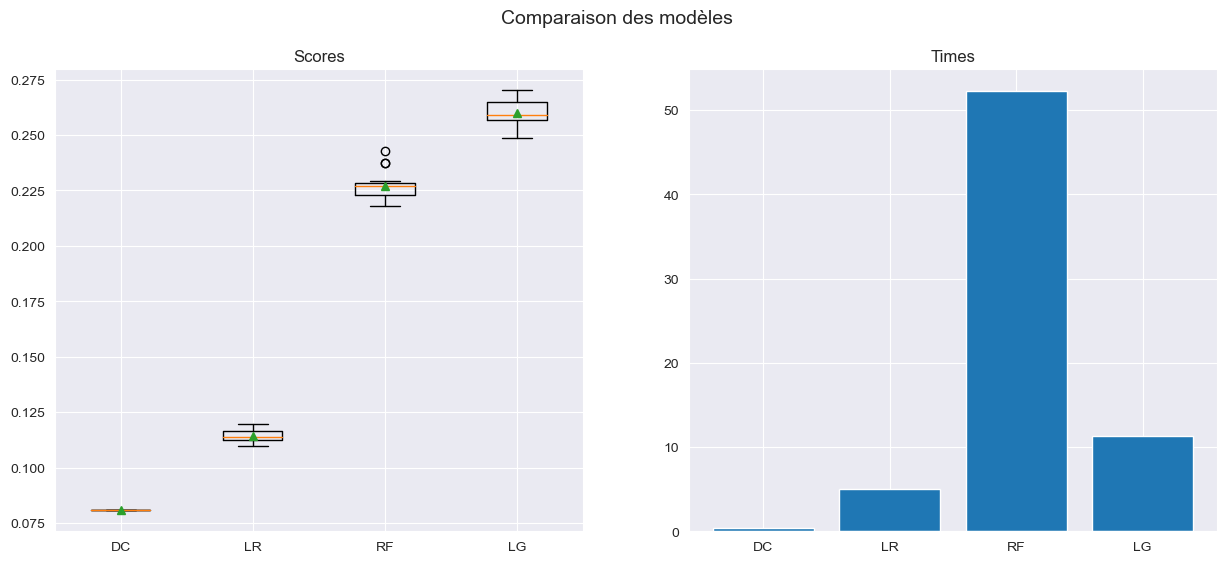

Meilleur modèle: LGBMClassifier(learning_rate=0.0244650752838748, max_depth=11, n_estimators=143)


In [23]:
# Comparaison des modèles
run_comparison = False # Saute cette étape si False
print(Fore.BLACK + Style.BRIGHT + Back.WHITE +
          f"Comparaison et sélection du modèle:\n"
          + Style.RESET_ALL)

import pickle

# Paramètres
debug = False
dataset = 'forced'
models_list = ml_dsf

if run_comparison:
    # Jeu de données et découpe stratifiée
    X, y, _ = load_dataset(set=dataset, debug=debug)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

    for model in models_list:
        # Entrainement des modèles sur le jeu d'entrainement
        print(f"Modèle {model['name']}:")
        eval = dict()
        eval['scores'], eval['time'] = model_evaluation(X_train, y_train,
                                                        model['pipeline'],
                                                        metric='average_precision',
                                                        n_splits=5, n_repeats=3,
                                                        random_state=0, verbose=False)
        model['eval'] = eval
        print(f"→ Score d'entrainement: {np.mean(eval['scores']):.3f} ({np.std(eval['scores'])})")

        # Score de test avec le modèle sans l'éventuel sampling
        test = dict()
        test['scores'], test['time'] = model_evaluation(X_test, y_test,
                                                        model['model'],
                                                        metric='average_precision',
                                                        n_splits=5, n_repeats=3,
                                                        random_state=0, verbose=False)
        print(f"→ Score de test sur le modèle: {np.mean(test['scores']):.3f} ({np.var(test['scores'])})")
        model['test'] = test

        # Score de test avec le modèle comprenant l'éventuel sampling
        if model['name']!='DC':
            sc_tp, t_tp = model_evaluation(X_test, y_test, model['pipeline'],
                                           metric='average_precision',
                                           n_splits=5, n_repeats=3,
                                           random_state=0, verbose=False)
            print(f"→ Score de test sur le pipeline: {np.mean(sc_tp):.3f} ({np.var(sc_tp)})")
        print('\n')

    # Sauvegarde de la liste des modèles
    filename = data_path + 'P7_models_' + dataset
    filename = filename + '_debug.sav' if debug else filename + '.sav'
    pickle.dump(ml_dsf, open(filename, 'wb'))

    # Affichage graphique de la comparaison des modèles
    display_models_eval(models_list)
    best_model = models_list[3]['model']
    print(f"Meilleur modèle:", best_model)

else:
    # Lecture de la liste des modèles enregistrée
    filename = data_path + 'P7_models_' + dataset
    filename = filename + '_debug.sav' if debug else filename + '.sav'
    models_list = pickle.load(open(filename, 'rb'))

    # Affichage des résultats
    for model in models_list:
        print(f"Modèle {model['name']}:")
        print(f"→ Score d'entrainement: {np.mean(model['eval']['scores']):.3f} ({np.std(model['eval']['scores'])})")
        print(f"→ Score de test : {np.mean(model['test']['scores']):.3f} ({np.var(model['test']['scores'])})\n")

    # Affichage graphique de la comparaison des modèles
    display_models_eval(models_list)
    best_model = models_list[3]['model']
    print(f"Meilleur modèle:", best_model)

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="model_opti_selected"></a>
### 4.3.5 - Optimisation du modèle sélectionné
Dans cette section, nous effectuons l'optimisation technique des hyperparamètres du modèle (voir notre méthodologique).

In [24]:
# Préparation du jeu de données et des paramètres pour l'optimisation des hyperparamètres
print(Fore.BLACK + Style.BRIGHT + Back.WHITE +
          f"Préparation du jeu de données et des paramètres pour l'optimisation des hyperparamètres du classifieur LightGBM:\n"
          + Style.RESET_ALL)

# Paramètres
debug = False
dataset = 'forced'
pca_var = 1
random_state = 0

# Chargement du dataset 'P7_data_preprocessed_woNaN_forced_normalized.csv'
X, y, cat_index = load_dataset(set=dataset, debug=debug)

# Features catégorielles
if pca_var>0 and pca_var<1:
    cat_index = []
else:
    print(f"Le dataset contient {len(cat_index)} features catégorielles", '\n')

# Réduction de dimensionnalité
from sklearn.decomposition import PCA
if pca_var>0 and pca_var<1:
    dimX = X.shape
    pca = PCA(n_components=pca_var, random_state=random_state)
    # Suppression des éventuelles colonnes '_nan' (se déduisent des autres catégories)
    n_categorical_columns = len(categorical_columns)
    categorical_columns = [col for col in categorical_columns if col[-4:]!='_nan']
    if len(categorical_columns)<n_categorical_columns:
        print(f"Suppression de {n_categorical_columns-len(categorical_columns)} features catégorielles correspondant aux NaN")
    # Normalisation des features catégorielles en vue du PCA
    for col in categorical_columns:
        X[col] = X[col] / np.sqrt(X[col].sum()/len(X[col])) if X[col].sum()>0 else 0
        X[col] = X[col] - X[col].mean()
    if get_df_nan_rate(X, verbose=False)>0:
        print("La réduction PCA ne peut s'effectuer avec des NaN: pas de réduction de dimension effectuée")
    else:
        X = pd.DataFrame(pca.fit_transform(X))
        print(f"Réduction de dimensionnalité de X (variance expliquée={pca_var:.3f}): {dimX} → {X.shape}", '\n')

# 'scale_pos_weight' paramètre de LightGBM concernant le déséquilibre des classes
n_sample_0 = len(y[y==0])
n_sample_1 = len(y[y==1])
scale_pos_weight = min(n_sample_0, n_sample_1) / max(n_sample_0, n_sample_1)
print(f"n_sample_0={n_sample_0}, n_sample_1={n_sample_1}, scale_pos_weight={scale_pos_weight}\n")

Préparation du jeu de données et des paramètres pour l'optimisation des hyperparamètres du classifieur LightGBM:

Dimensions du jeu de données: X = (307507, 795), y = (307507,)

Le dataset contient 168 features catégorielles 

n_sample_0=282682, n_sample_1=24825, scale_pos_weight=0.08781952865764357



In [25]:
run_optimisation = False # Saute l'étape d'optimisation si False

import sklearn
import lightgbm
print("Versions des librairies des modèles:")
print('- Scikit-learn : ' + sklearn.__version__)
print('- LightGBM : ' + lightgbm.__version__)
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import LightGBMPruningCallback
from warnings import simplefilter, filterwarnings, resetwarnings

def objective_lgbm(trial, X, y, metric, n_splits,
                   cat_index, is_unbalanced=True,
                   random_state=None, njobs=None):
    """
    Fonction 'objective' telle que spécifiée par la librairie
        'Optuna'.
        - Définit les plages des paramètres à optimiser.
        - Découple le jeu en n_splits pour la validation croisée.
        - Entraine le modèle avec les paramètres issus d'Optuna.
        - Calcule le score avec la métrique spécifiée.
        Note: l'argument 'callbacks' de fit permet l'arrêt
        anticipé si la métrique n'évolue plus ou avec la fonction
        d'élagage d'Optuna.
    :param trial: paramètre d'Optuna, correspond à un essai.
    :param X: Dataframe, matrice d'entrée.
    :param y: Series, matrice des classes vraies.
    :param metric: str ou scorer, métrique sous forme de str ou telle
        que spécifiée par LightGBM.
    :param n_splits: int, nombre de découpes du jeu de données
        avec StratifiedKFold pour la validation croisée.
    :param cat_index: index des colonnes de type catégorielles
        (pd.Categorical).
    :param is_unbalanced: bool, True si le jeu est déséquilibré.
    :param random_state: int, random_state.
    :param njobs: int, spécifier -1 pour utiliser tous les
        processus disponibles en parallèle.
    :return: float, score de l'essai ('trial').
    """
    # Plages des paramètres
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
    }

    # Calcul du score en validations croisées
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    scores = np.empty(n_splits)
    simplefilter(action='ignore')
    for idx, (train_idx, eval_idx) in enumerate(cv.split(X, y)):
        X_train, X_eval = X.iloc[train_idx], X.iloc[eval_idx]
        y_train, y_eval = y.iloc[train_idx], y.iloc[eval_idx]
        clf = LGBMClassifier(objective='binary',
                             **param_grid,
                             is_unbalance=is_unbalanced,
                             #scale_pos_weight=scale_pos_weight,
                             verbosity=0,
                             random_state=random_state, n_jobs=njobs)
        clf.fit(X_train, y_train,
                eval_set=[(X_eval, y_eval)],
                eval_metric=metric,
                callbacks=[early_stopping(stopping_rounds=100, first_metric_only=True, verbose=False),
                           LightGBMPruningCallback(trial, metric=metric)],
                categorical_feature = cat_index)
        y_pred = clf.predict_proba(X_eval)[:, 1]
        scores[idx] = average_precision_score(y_eval, y_pred)
        print(Fore.GREEN + f"score courant: {scores[idx]}" + Style.RESET_ALL)

    resetwarnings()
    return np.mean(scores)

# Study
study_name = 'lgb_tech' + '_' + dataset + '_debug' if debug else 'lgb_tech' + '_' + dataset
storage = 'sqlite:///' + data_path + study_name + '.db'

# Etude d'optimisation des hyperparamètres
if run_optimisation:
    metric='average_precision'
    n_jobs = -1
    n_splits = 5
    n_trials = 1 if debug else 250
    study = optuna.create_study(study_name=study_name,
                                storage=storage,
                                load_if_exists=True,
                                direction="maximize",
                                sampler=optuna.samplers.TPESampler())
    func = lambda trial: objective_lgbm(trial, X, y, metric, n_splits, cat_index,
                                        random_state=random_state, njobs=n_jobs)
    study.optimize(func, n_trials=n_trials)

Versions des librairies des modèles:
- Scikit-learn : 1.1.1
- LightGBM : 3.2.1


In [26]:
# Affiche le résultat de l'optimisation
print(Fore.BLACK + Style.BRIGHT + Back.WHITE +
          f"Résultat de l'optimisation des hyperparamètres du classifieur LightGBM':\n"
          + Style.RESET_ALL)
study_name = 'lgb_tech' + '_' + dataset + '_debug' if debug else 'lgb_tech' + '_' + dataset
storage = 'sqlite:///' + data_path + study_name + '.db'
study = optuna.study.load_study(study_name=study_name, storage=storage)
print(f"L'étude comprend {len(study.trials)} essais")
best_trial = study.best_trial
print(f"score = {best_trial.value}")
print(f"Meilleurs hyperparamètres: {best_trial.params}")

# Affichage graphique
#fig = optuna.visualization.plot_contour(study)
#fig.show()
fig = optuna.visualization.plot_optimization_history(study)
fig.show()
fig = optuna.visualization.plot_param_importances(study)
fig.show()

Résultat de l'optimisation des hyperparamètres du classifieur LightGBM':

L'étude comprend 250 essais
score = 0.28360310633185437
Meilleurs hyperparamètres: {'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'lambda_l1': 80, 'lambda_l2': 90, 'learning_rate': 0.08267606248943428, 'max_depth': 11, 'min_data_in_leaf': 500, 'min_gain_to_split': 12.508610242621682, 'n_estimators': 10000, 'num_leaves': 3000}


In [27]:
# Classifier LightGBM
run_training = False # False pour sauter l'étape de training

import joblib
import pickle
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + f"Modélisation technique:\n" + Style.RESET_ALL)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

if run_training:
    # Entrainement du meilleur modèle
    params = best_trial.params
    clf = LGBMClassifier(objective='binary',
                         **params,
                         is_unbalance=True,
                         #scale_pos_weight=scale_pos_weight,
                         verbosity=-1,
                         random_state=0,
                         n_jobs=-1)
    print(f"Entrainement du modèle {clf}")
    start_time = time.time()
    clf.fit(X_train, y_train)
    elapsed = time.time() - start_time
    print(f"Entrainement exécuté en {elapsed_format(elapsed)}")
    joblib.dump(clf, data_path + 'lgb_tech.joblib')
    with open(data_path + 'lgb_tech.pkl', 'wb') as file:
        pickle.dump(clf, file)
    print("Modèle enregistré dans les fichiers 'lgb_tech.joblib' et 'lgb_tech.pkl'")
else:
    clf = joblib.load(data_path + 'lgb_tech.joblib')
    print("Modèle:", clf)

Modélisation technique:

Modèle: LGBMClassifier(bagging_fraction=0.8, bagging_freq=1,
               feature_fraction=0.30000000000000004, is_unbalance=True,
               lambda_l1=80, lambda_l2=90, learning_rate=0.08267606248943428,
               max_depth=11, min_data_in_leaf=500,
               min_gain_to_split=12.508610242621682, n_estimators=10000,
               num_leaves=3000, objective='binary', random_state=0,
               verbosity=-1)


Score de test (average_precision) = 0.2763
Meilleur fb_score (beta=1.92) = 0.4432 (0.691,0.191), pour le seuil = 0.4894


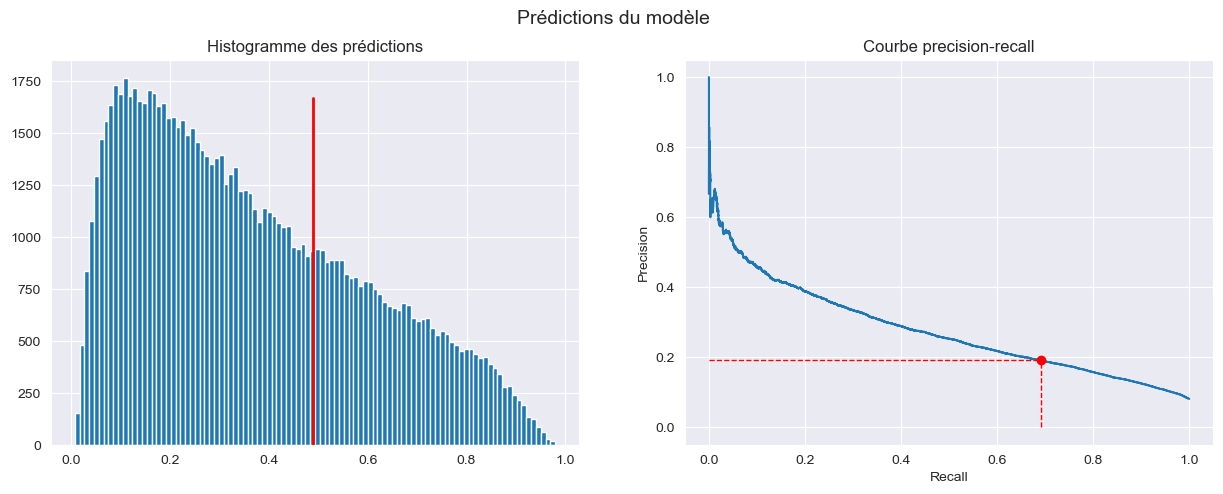

Matrice de confusion en nombre d'échantillon:


pred_0  pred_1
0   63897   20908
1    2401    5047

Matrice de confusion en % du nombre d'échantillons de test:


pred_0 pred_1
0  69.3%  22.7%
1   2.6%   5.5%

TN=63897, FP=20908, FN=2401, TP=5047
Rapport FN / FP = 0.115


In [28]:
# Prédiction sur l'échantillon de test
from sklearn.metrics import precision_recall_curve
y_score = clf.predict_proba(X_test)[:, 1]
print(f"Score de test (average_precision) = {average_precision_score(y_test, y_score):.4f}")

# Calcul du seuil optimum technique de probabilité
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
#thresholds = np.append(thresholds, 1)
beta = 1.92  # 1.92 correspond à FN/FP=0.105
fb_score = ((1 + beta ** 2) * precision * recall) / (beta ** 2 * precision + recall)
idx_max = np.argmax(fb_score)
threshold = thresholds[idx_max]
print(f"Meilleur fb_score (beta={beta}) = {np.max(fb_score):.4f} ({recall[idx_max]:.3f},"
      f"{precision[idx_max]:.3f}), pour le seuil = {threshold:.4f}")
#y_pred = np.array([1 if prob >= threshold else 0 for prob in y_score])

# Affichage graphique
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.hist(y_score, bins=100)
hist_max = ax1.get_ylim()[1]
ax1.plot([threshold, threshold], [0, 0.9 * ax1.get_ylim()[1]], lw=2, color='r')
ax1.set_title("Histogramme des prédictions")
ax2.plot(recall, precision)
ax2.plot([recall[idx_max], recall[idx_max]], [0, precision[idx_max]], lw=1, ls='--', color='r')
ax2.plot([0, recall[idx_max]], [precision[idx_max], precision[idx_max]], lw=1, ls='--', color='r')
ax2.plot(recall[idx_max], precision[idx_max], 'ro')
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("Courbe precision-recall")
plt.suptitle("Prédictions du modèle", fontsize=14)
plt.show()

# Matrice de confusion technique
from sklearn.metrics import confusion_matrix
fbeta_thr = False
thr = 0.5 if not fbeta_thr else threshold
y_pred = np.array([1 if prob >= thr else 0 for prob in y_score])
cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion en nombre d'échantillon:")
display(pd.DataFrame(cm, index=['0', '1'], columns=['pred_0', 'pred_1']))
cm_pc = pd.DataFrame(100 * cm / np.sum(cm.flatten()), index=['0', '1'], columns=['pred_0', 'pred_1'])
for col in cm_pc.columns:
    cm_pc[col] = cm_pc[col].map('{:.1f}%'.format)
print("Matrice de confusion en % du nombre d'échantillons de test:")
display(cm_pc)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Rapport FN / FP = {float(fn) / fp:.3f}")

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="Model_business"></a>
# 5 - Approche métier

<a id="Model_buss_opti"></a>
# 5.1 - Optimisation du modèle du point de vue métier
Dans cette section, nous effectuons l'optimisation métier des hyperparamètres du modèle (voir notre méthodologique).

In [29]:
# Préparation du jeu de données et des paramètres pour l'optimisation des hyperparamètres
print(Fore.BLACK + Style.BRIGHT + Back.WHITE +
          f"Préparation du jeu de données et des paramètres pour l'optimisation des hyperparamètres du classifieur LightGBM:\n"
          + Style.RESET_ALL)

# Paramètres
dataset = 'forced'
debug = False

# Chargement du dataset 'P7_data_preprocessed_woNaN_forced_normalized.csv'
X, y, cat_index = load_dataset(set=dataset, debug=debug)
print(f"Le dataset contient {len(cat_index)} features catégorielles", '\n')

# 'scale_pos_weight' paramètre de LightGBM concernant le déséquilibre des classes
n_sample_0 = len(y[y==0])
n_sample_1 = len(y[y==1])
scale_pos_weight = min(n_sample_0, n_sample_1) / max(n_sample_0, n_sample_1)
print(f"n_sample_0={n_sample_0}, n_sample_1={n_sample_1}, scale_pos_weight={scale_pos_weight}\n")

Préparation du jeu de données et des paramètres pour l'optimisation des hyperparamètres du classifieur LightGBM:

Dimensions du jeu de données: X = (307507, 795), y = (307507,)

Le dataset contient 168 features catégorielles 

n_sample_0=282682, n_sample_1=24825, scale_pos_weight=0.08781952865764357



In [30]:
run_optimisation = False # Saute l'étape d'optimisation si False

import sklearn
import lightgbm
print("Versions des librairies des modèles:")
print('- Scikit-learn : ' + sklearn.__version__)
print('- LightGBM : ' + lightgbm.__version__)
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import precision_recall_curve, fbeta_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import LightGBMPruningCallback
from warnings import simplefilter, filterwarnings, resetwarnings
from math import isnan

def objective_buss(trial, X, y, scale_pos_weight , cat_index,
                   random_state=None, njobs=None):
    """
    Fonction 'objective' telle que spécifiée par la librairie
        'Optuna'.
        - Définit les plages des paramètres à optimiser.
        - Découple le jeu en n_splits pour la validation croisée.
        - Entraine le modèle avec les paramètres issus d'Optuna.
        - Calcule le score avec la métrique spécifiée.
        Note: l'argument 'callbacks' de fit permet l'arrêt
        anticipé si la métrique n'évolue plus ou avec la fonction
        d'élagage d'Optuna.
    :param trial: paramètre d'Optuna, correspond à un essai.
    :param X: Dataframe, matrice d'entrée.
    :param y: Series, matrice des classes vraies.
    :return: float, score de l'essai ('trial').
    """
    # Plages des paramètres
    params = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
    }

    # Métrique
    def fbeta_metric(y_true, y_score, beta=1):
        precision, recall, thresholds = precision_recall_curve(y_true, y_score)
        fscore = ((1 + beta**2) * precision * recall) / (beta**2 * precision + recall)
        score = np.max(fscore)
        score = 0 if isnan(score) else score
        #print(f"score={score}")
        return score

    def fb_funcmetric(y_true, y_score):
        is_higher_better = True
        score = fbeta_metric(y_true, y_score, beta=2)
        return 'fb_score', score, is_higher_better

    # Callbacks
    earlystopping_callback = early_stopping(stopping_rounds=100, first_metric_only=True, verbose=False)
    pruning_callback = LightGBMPruningCallback(trial, 'fb_score')

    # Calcul du score en validations croisées
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    scores = np.empty(n_splits)
    simplefilter(action='ignore')
    for idx, (train_idx, eval_idx) in enumerate(cv.split(X, y)):
        X_train, X_eval = X.iloc[train_idx], X.iloc[eval_idx]
        y_train, y_eval = y.iloc[train_idx], y.iloc[eval_idx]
        clf = LGBMClassifier(objective='binary',
                             **params,
                             is_unbalance=True,
                             #scale_pos_weight=scale_pos_weight,
                             #verbosity=0,
                             random_state=random_state,
                             n_jobs=njobs)
        clf.fit(X_train, y_train,
                eval_set=[(X_eval, y_eval)],
                eval_metric=fb_funcmetric,
                #callbacks=[early_stopping(stopping_rounds=100, first_metric_only=True, verbose=False)],
                callbacks=[earlystopping_callback, pruning_callback],
                #verbose_eval=False,
                categorical_feature = cat_index)
        y_score = clf.predict_proba(X_eval)[:, 1]
        scores[idx] = fb_funcmetric(y_eval, y_score)[1]
        print(Fore.GREEN + f"score courant: {scores[idx]}" + Style.RESET_ALL)

    resetwarnings()
    return np.mean(scores)

# Study
study_name = 'lgb_buss' + '_' + dataset + '_debug' if debug else 'lgb_buss' + '_' + dataset
storage = 'sqlite:///' + data_path + study_name + '.db'

# Etude d'optimisation des hyperparamètres
if run_optimisation:
    n_trials = 1 if debug else 300
    study = optuna.create_study(study_name=study_name,
                                storage=storage,
                                load_if_exists=True,
                                direction="maximize",
                                sampler=optuna.samplers.TPESampler())
    func = lambda trial: objective_buss(trial, X, y, scale_pos_weight , cat_index,
                                        random_state=0, njobs=-1)
    study.optimize(func, n_trials=n_trials)

Versions des librairies des modèles:
- Scikit-learn : 1.1.1
- LightGBM : 3.2.1


In [31]:
# Affiche le résultat de l'optimisation
print(Fore.BLACK + Style.BRIGHT + Back.WHITE +
          f"Résultat de l'optimisation des hyperparamètres du classifieur LightGBM':\n"
          + Style.RESET_ALL)
study_name = 'lgb_buss' + '_' + dataset + '_debug' if debug else 'lgb_buss' + '_' + dataset
storage = 'sqlite:///' + data_path + study_name + '.db'
study = optuna.study.load_study(study_name=study_name, storage=storage)
print(f"L'étude comprend {len(study.trials)} essais")
best_trial = study.best_trial
print(f"score = {best_trial.value}")
print(f"Meilleurs hyperparamètres: {best_trial.params}")

# Affichage graphique
#fig = optuna.visualization.plot_contour(study)
#fig.show()
fig = optuna.visualization.plot_optimization_history(study)
fig.show()
fig = optuna.visualization.plot_param_importances(study)
fig.show()

Résultat de l'optimisation des hyperparamètres du classifieur LightGBM':

L'étude comprend 300 essais
score = 0.38232923028392746
Meilleurs hyperparamètres: {'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5, 'lambda_l1': 90, 'lambda_l2': 25, 'learning_rate': 0.08370336016951353, 'max_depth': 11, 'min_data_in_leaf': 3000, 'min_gain_to_split': 12.576853157498372, 'n_estimators': 10000, 'num_leaves': 2800}


Modélisation métier:

Modèle: LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, feature_fraction=0.5,
               is_unbalance=True, lambda_l1=90, lambda_l2=25,
               learning_rate=0.08370336016951353, max_depth=11,
               min_data_in_leaf=3000, min_gain_to_split=12.576853157498372,
               n_estimators=10000, num_leaves=2800, objective='binary',
               random_state=0, verbosity=-1) 

Score de test (f2 score) = 0.4549, average_precision=0.2756

Concordance des étiquettes de prédiction avec seuil=0.5 (vert): 92253 sur 92253 

Meilleur f2 score = 0.4549 (0.711,0.186), pour le seuil=0.4894 (rouge)
Concordance des étiquettes de prédiction avec seuil=0.4894: 91156 sur 92253


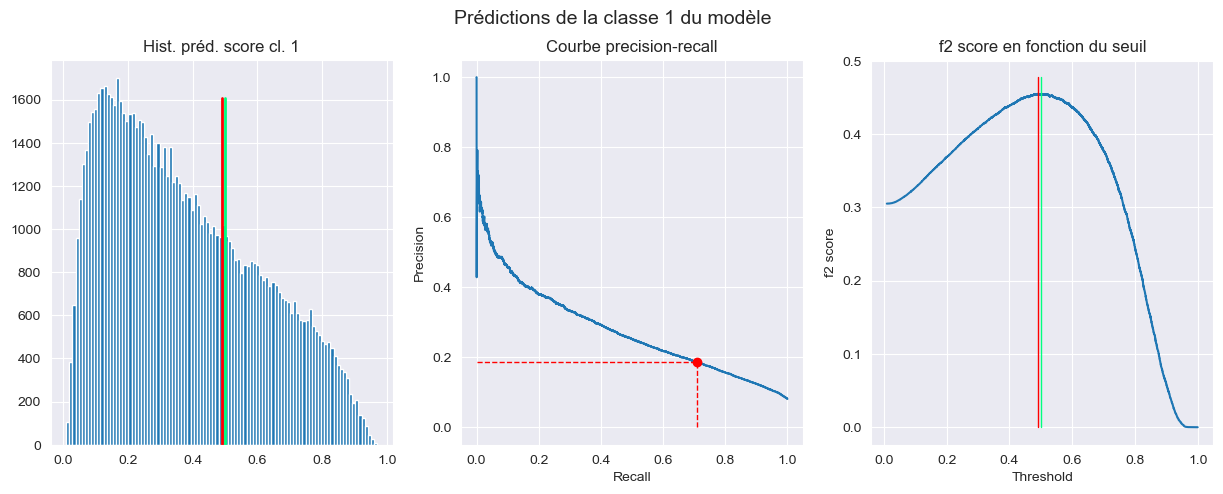

Matrice de confusion en nombre d'échantillon:


pred_0  pred_1
0   62698   22107
1    2274    5174

Matrice de confusion en % du nombre d'échantillons de test:


pred_0 pred_1
0  68.0%  24.0%
1   2.5%   5.6%

TN=62698, FP=22107, FN=2274, TP=5174
Rapport FN / FP = 0.10


In [32]:
# Classifier LightGBM
run_training = False # False pour sauter l'étape de training

import joblib
import pickle
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + f"Modélisation métier:\n" + Style.RESET_ALL)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

if run_training:
    # Entrainement du meilleur modèle
    params = best_trial.params
    clf = LGBMClassifier(objective='binary',
                         **params,
                         is_unbalance=True,
                         #scale_pos_weight=scale_pos_weight,
                         verbosity=-1,
                         random_state=0,
                         n_jobs=-1)
    print(f"Entrainement du modèle {clf}")
    start_time = time.time()
    clf.fit(X_train, y_train)
    elapsed = time.time() - start_time
    print(f"Entrainement exécuté en {elapsed_format(elapsed)}")
    joblib.dump(clf, data_path + 'lgb_buss.joblib')
    with open(data_path + 'lgb_buss.pkl', 'wb') as file:
        pickle.dump(clf, file)
    print("Modèle enregistré dans les fichiers 'lgb_buss.joblib' et 'lgb_buss.pkl'")
else:
    clf = joblib.load(data_path + 'lgb_buss.joblib')
    print("Modèle:", clf, '\n')

# Prédiction sur l'échantillon de test

# Probabilités de la classe 1
y_score = clf.predict_proba(X_test)[:, 1]
#print("\nStatistiques sur la probabilité de la classe 1 de l'échantillon de test:")
#stats_y_score = pd.DataFrame(y_score).describe()
#stats_y_score.columns = ['prob(1)']
#display(stats_y_score)

# Courbe precision-recal et f2_score maximum
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
thresholds = np.append(thresholds, 1)
beta = 2
fb_score = ((1 + beta**2) * precision * recall) / (beta**2 * precision + recall)
print(f"Score de test (f{beta} score) = {np.max(fb_score):.4f}, "
      f"average_precision={average_precision_score(y_test, y_score):.4f}\n")

# Etiquettes de prédiction avec seuil=0.5
y_pred_clf = clf.predict(X_test)
#np.savetxt(data_path + 'P7_target_prediction.csv', y_pred_clf, fmt='%i', delimiter=';')
y_pred = np.array([1 if prob >= 0.5 else 0 for prob in y_score])
print(f"Concordance des étiquettes de prédiction avec seuil=0.5 (vert):",
      (y_pred==y_pred_clf).sum(), "sur", len(y_pred_clf), '\n')

# Seuil optimum de probabilité
idx_max = np.argmax(fb_score)
threshold = thresholds[idx_max]
print(f"Meilleur f{beta} score = {np.max(fb_score):.4f} ({recall[idx_max]:.3f},"
      f"{precision[idx_max]:.3f}), pour le seuil={threshold:.4f} (rouge)")
y_pred = np.array([1 if prob >= threshold else 0 for prob in y_score])
print(f"Concordance des étiquettes de prédiction avec seuil={threshold:.4f}:",
      (y_pred==y_pred_clf).sum(), "sur", len(y_pred_clf))

# Affichage graphique
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax1.hist(y_score, bins=100)
hist_max = ax1.get_ylim()[1]
ax1.plot([0.5, 0.5], [0, 0.9 * ax1.get_ylim()[1]], lw=2, color='springgreen')
ax1.plot([threshold, threshold], [0, 0.9 * ax1.get_ylim()[1]], lw=2, color='r')
ax1.set_title("Hist. préd. score cl. 1")
ax2.plot(recall, precision)
ax2.plot([recall[idx_max], recall[idx_max]], [0, precision[idx_max]], lw=1, ls='--', color='r')
ax2.plot([0, recall[idx_max]], [precision[idx_max], precision[idx_max]], lw=1, ls='--', color='r')
ax2.plot(recall[idx_max], precision[idx_max], 'ro')
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("Courbe precision-recall")
ax3.plot(thresholds, fb_score)
ymax = ax3.get_ylim()[1]
ax3.plot([0.5, 0.5], [0, ymax], lw=1, color='springgreen')
ax3.plot([threshold, threshold], [0, ymax], lw=1, color='r')
ax3.set_xlabel("Threshold")
ax3.set_ylabel(f"f{beta} score")
ax3.set_title(f"f{beta} score en fonction du seuil")
plt.suptitle("Prédictions de la classe 1 du modèle", fontsize=14)
plt.show()

# Matrice de confusion
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_clf)
print("Matrice de confusion en nombre d'échantillon:")
display(pd.DataFrame(cm, index=['0', '1'], columns=['pred_0', 'pred_1']))
cm_pc = pd.DataFrame(100 * cm / np.sum(cm.flatten()), index=['0', '1'], columns=['pred_0', 'pred_1'])
for col in cm_pc.columns:
    cm_pc[col] = cm_pc[col].map('{:.1f}%'.format)
print("Matrice de confusion en % du nombre d'échantillons de test:")
display(cm_pc)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_clf).ravel()
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Rapport FN / FP = {float(fn) / fp:.2f}")

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

In [33]:
# Ensemble des données X et y afin pour le dashboard
run_dashboard_data = False # False pour sauter cette étape
import json
print(Fore.BLACK + Style.BRIGHT + Back.WHITE +
      f"Données X et y, liste de features:\n"
      + Style.RESET_ALL)
if run_dashboard_data:
    df = pd.read_csv(data_path + 'P7_data_preprocessed_woNaN_forced_normalized.csv', sep=';')
    df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    non_input_features_list = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
    with open(data_path + 'P7_cat_features.txt', "r") as file:
        categorical_columns = json.load(file)
    categorical_columns = [re.sub('[^A-Za-z0-9_]+', '', f) for f in categorical_columns if f not in non_input_features_list]
    for col in categorical_columns:
        df[col] = pd.Categorical(df[col])
    x_columns = [f for f in df.columns.tolist() if f not in non_input_features_list]
    X = df[x_columns].copy()
    df['y_score'] = clf.predict_proba(X)[:, 1]
    df['y_pred'] = clf.predict(X)
    df_pred = df[['SK_ID_CURR', 'TARGET', 'y_pred', 'y_score']].copy()
    df_pred.columns = ['id', 'y_true', 'y_pred', 'y_score']
    df_pred.to_csv(data_path + 'P7_dashboard_ydata.csv', sep=';', index=False)
    X.to_csv(data_path + 'P7_dashboard_Xdata.csv', sep=';', index=False)
    features_list = X.columns.tolist()
    with open(data_path + 'P7_features_list.txt', "w") as file:
        json.dump(features_list, file)
    del df
    gc.collect()
else:
    df_pred = pd.read_csv(data_path + 'P7_dashboard_ydata.csv', sep=';')
    df_pred[['id', 'y_pred']] = df_pred[['id', 'y_pred']].astype(dtype=int)
    df_pred['y_true'] = df_pred['y_true'].map('{:.0f}'.format)
    X = pd.read_csv(data_path + 'P7_dashboard_Xdata.csv', sep=';')
    features_list = X.columns.tolist()
    with open(data_path + 'P7_features_list.txt', "r") as file:
        fl = json.load(file)
    are_fl_different = np.array([True for f1, f2 in zip(fl, features_list) if f1!=f2]).any()
    print(f"Concordance de la liste des features de X avec la liste enregistrée: {not are_fl_different}")
    if are_fl_different:
        issue_list = [(f1, f2) for f1, f2 in zip(fl, features_list) if f1!=f2]
        print("Liste des discordances:")
        for item in issue_list:
            print(f"- {item}")
print("Dimensions de la table des prédictions:", df_pred.shape)
display(df_pred.head())
print(f"Nombre de features en entrée du modèle: {len(features_list)}")

Données X et y, liste de features:

Concordance de la liste des features de X avec la liste enregistrée: True
Dimensions de la table des prédictions: (356251, 4)


id   y_true  y_pred  y_score
0  100002    1       1     0.880 
1  100003    0       0     0.096 
2  100004    0       0     0.193 
3  100006    0       0     0.332 
4  100007    0       0     0.433

Nombre de features en entrée du modèle: 795


<a id="Model_buss_shap"></a>
# 5.2 - Analyse de l'impact des features
Dans cette section, nous utilisons la librairie Shap afin de nous aider à interpréter le modèle métier et préparer les éléments que nous ferons figurer dans le dashboard.

Analyse de l'impact des features:

Version de la librairie SHAP : 0.39.0
SHAP values: (356251, 795, 2) 

Matrice totale shap_values: (356251, 795, 2)
→ '.values' (valeurs de Shapley): (356251, 795, 2)
→ '.values' (valeurs de Shapley), pour la classe 1 (356251, 795)
→ '.base_values' (valeurs de base): (356251, 2)
→ '.base_values' (valeurs de base), valeurs uniques pour les classes {0, 1}: [-0.66455009  0.66455009]
  → base_values, valeur de base pour la classe 0 [0.66455009]
  → base_values, valeur de base pour la classe 1 [-0.66455009]
→ '.data' (copie des données d'entrée X) (356251, 795) False
→ '.feature_names' (label des features de X) 795 ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH'] 

Impact des features sur la prédiction de la classe 1


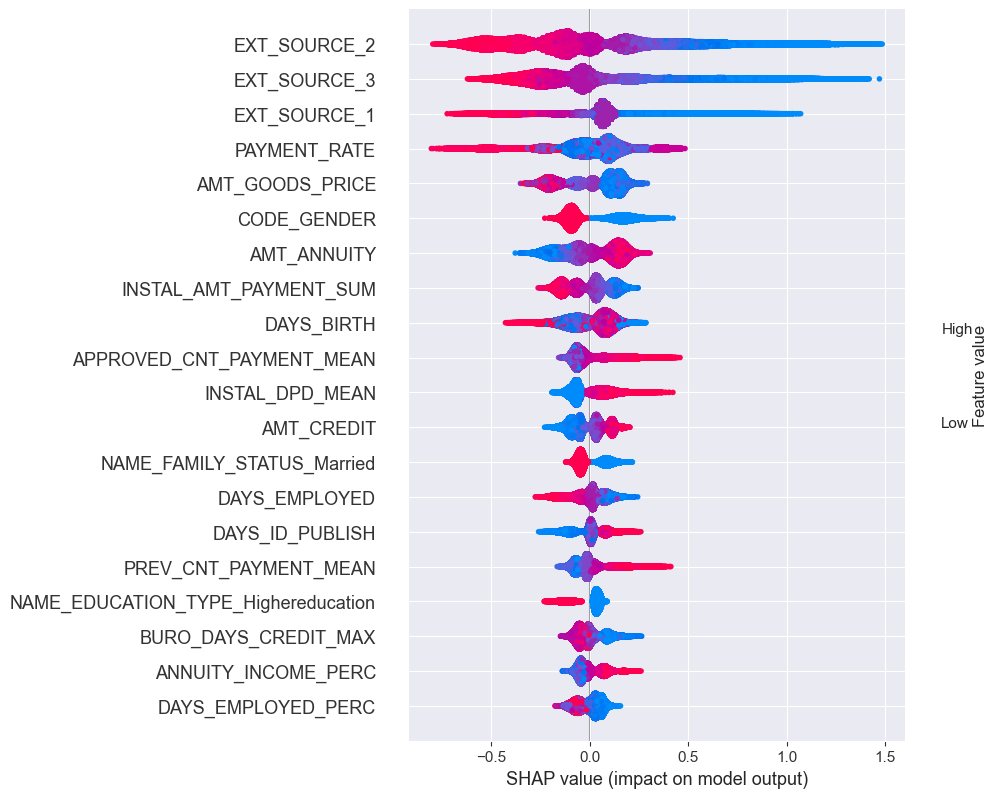

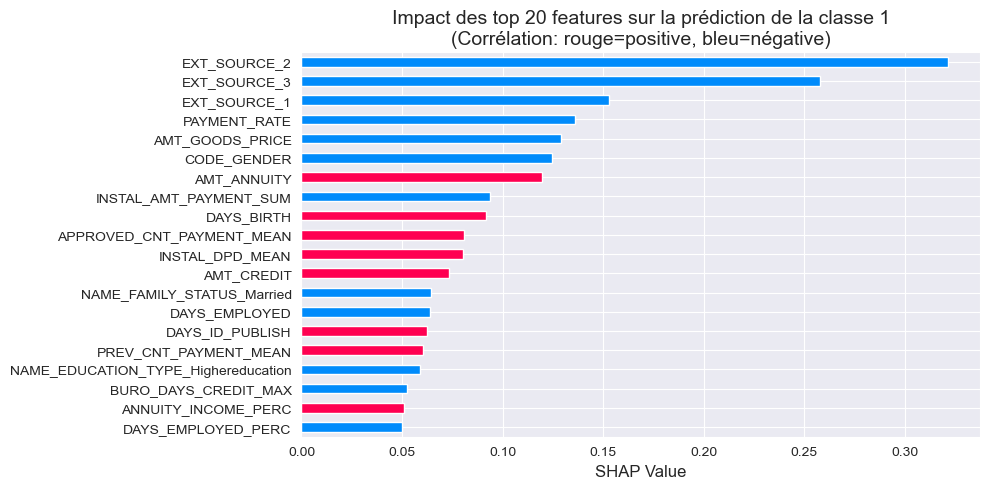

Impact de la feature PAYMENT_RATE sur la prédiction de la classe 1


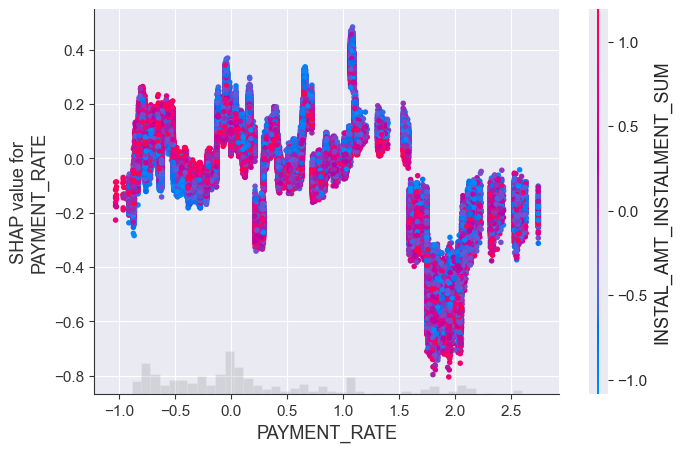

Features prépondérantes dans la prédiction de la classe 1 pour l'individu 0


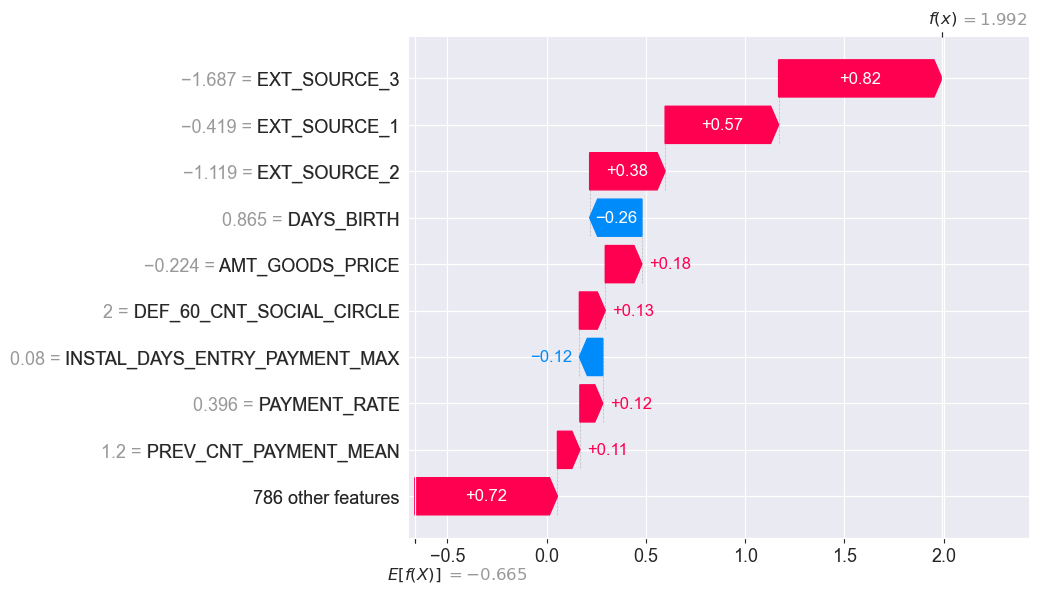

In [34]:
# Analyse de l'importance des features avec SHAP
run_shap_values = False # False pour sauter cette étape
import pickle
import shap
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + f"Analyse de l'impact des features:\n" + Style.RESET_ALL)
print(f'Version de la librairie SHAP : {shap.__version__}')

# Calcul des SHAP values
if run_shap_values:
    start_time = time.time()
    explainer = shap.Explainer(clf)
    shap_values = explainer(X)
    elapsed = time.time() - start_time
    print(f"SHAP values exécuté en {elapsed_format(elapsed)}")
    with open(data_path + "P7_shap_values.pkl", 'wb') as file:
        pickle.dump(shap_values, file)
else:
    with open(data_path + "P7_shap_values.pkl", 'rb') as file:
        shap_values = pickle.load(file)
print("SHAP values:", shap_values.shape, '\n')

# shap_values
clarify_shap_values = True # True pour afficher les informations
if clarify_shap_values:
    print("Matrice totale shap_values:", shap_values.shape)
    print("→ '.values' (valeurs de Shapley):", shap_values.values.shape)
    print("→ '.values' (valeurs de Shapley), pour la classe 1", shap_values[..., 1].values.shape)
    print("→ '.base_values' (valeurs de base):", shap_values.base_values.shape)
    print("→ '.base_values' (valeurs de base), valeurs uniques pour les classes {0, 1}:", np.unique(shap_values.base_values))
    print("  → base_values, valeur de base pour la classe 0", np.unique(shap_values[..., 0].base_values))
    print("  → base_values, valeur de base pour la classe 1", np.unique(shap_values[..., 1].base_values))
    print("→ '.data' (copie des données d'entrée X)", shap_values.data.shape, (shap_values.data==X.values).all())
    print("→ '.feature_names' (label des features de X)", len(shap_values.feature_names), shap_values.feature_names[:10], '\n')
del X
gc.collect()

# Affichage graphique de l'impact des features sur la prédiction
class_value = 1
print(f"Impact des features sur la prédiction de la classe {class_value}")
shap.initjs()
shap.summary_plot(shap_values[...,class_value], shap_values.data)
shap_feature_impact(shap_values, class_value=1, top_n=20,
                    save=fig_path+f"P7_shap_feature_impact_class{class_value}.png")

# Affichage graphique de l'impact d'une feature sur la prédiction
feature = 'PAYMENT_RATE'
class_value = 1
print(f"Impact de la feature {feature} sur la prédiction de la classe {class_value}")
shap.plots.scatter(shap_values[:, feature, class_value], color=shap_values[..., class_value])

# Affichage graphique des features prépondérantes dans la prédiction d'un individu
sample = 0
class_value = 1
print(f"Features prépondérantes dans la prédiction de la classe {class_value} pour l'individu {sample}")
shap.plots.waterfall(shap_values[sample][:, class_value])

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

N° de client, acceptation du crédit et score:


id         100257
y_true          0
y_pred          0
y_score     0.482
Name: 220, dtype: object

Prédiction du modèle: 0.4818
Somme des valeurs de Shapley pour le cient N°100257: 0.5915

Features d'impact local pour la prédiction de la classe 1 (y_pred=0) pour le client N°100257


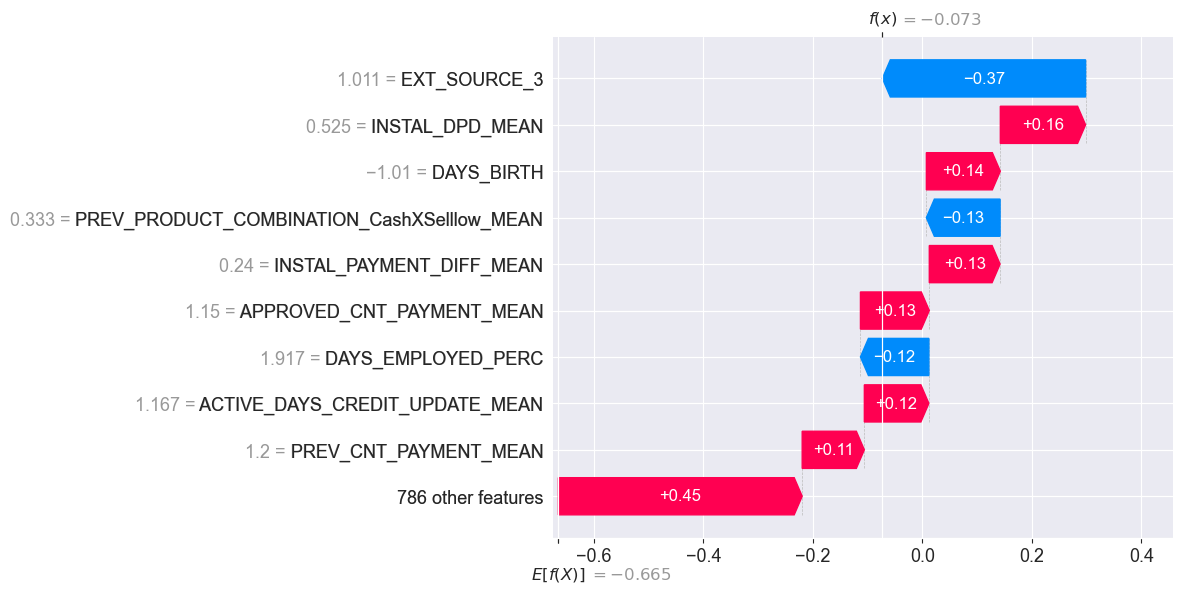

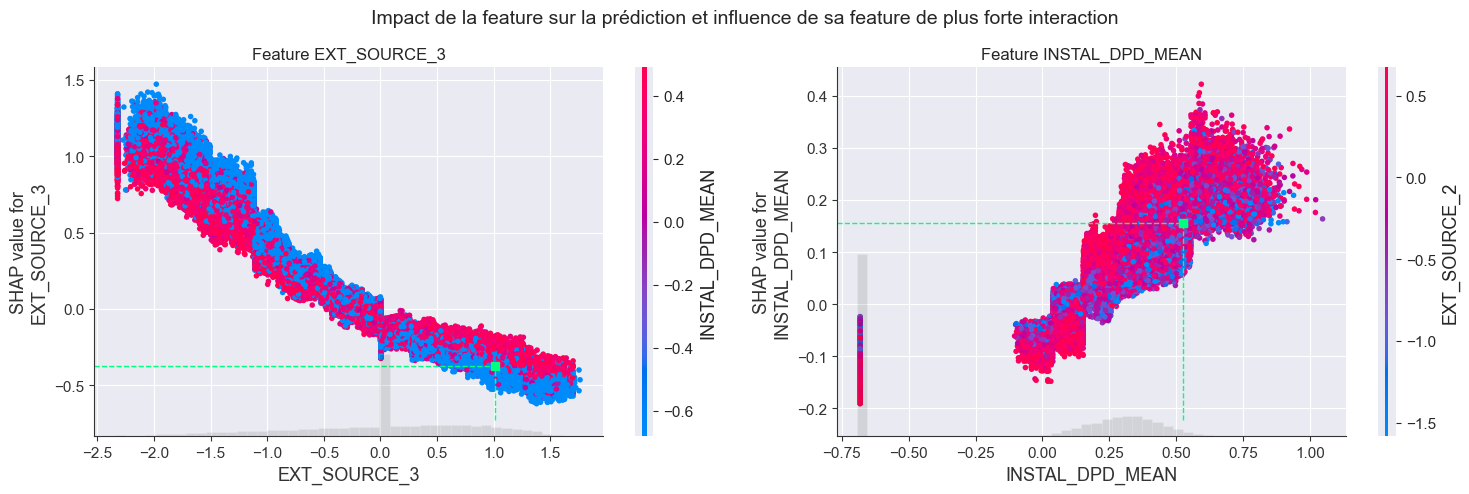

In [35]:
# Affichage graphique des features prépondérantes dans la prédiction d'un individu
id = 100257
sample = int(df_pred[df_pred['id']==id].index[0])
class_value = 1
print(f"N° de client, acceptation du crédit et score:")
display(df_pred.iloc[sample,:])
X_sample = shap_values.data[sample].copy().reshape(1, -1)
print(f"Prédiction du modèle: {clf.predict_proba(X_sample)[:, 1][0]:.4f}")
print(f"Somme des valeurs de Shapley pour le cient N°{df_pred.at[sample, 'id']}: "
      f"{shap_values[..., 1].values[sample].sum():.4f}\n")
print(f"Features d'impact local pour la prédiction de la classe {class_value} "
      f"(y_pred={df_pred.at[sample,'y_pred']}) pour le client N°{df_pred.at[sample, 'id']}")
shap.plots.waterfall(shap_values[sample][:, class_value])

feature_1 = 'EXT_SOURCE_3'
feature_1_iloc = shap_values.feature_names.index(feature_1)
feature_1_value = shap_values.data[sample, feature_1_iloc]
feature_1_shap_value = shap_values[sample, feature_1, class_value].values
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
shap.plots.scatter(shap_values[:, feature_1, class_value], color=shap_values[..., class_value], ax=ax1, show=False)
ax1.plot([feature_1_value, feature_1_value], [ax1.get_ylim()[0], feature_1_shap_value], ls='--', lw=1, color='springgreen')
ax1.plot([ax1.get_xlim()[0], feature_1_value], [feature_1_shap_value, feature_1_shap_value], ls='--', lw=1, color='springgreen')
ax1.plot(feature_1_value, feature_1_shap_value, marker='s', color='springgreen')
ax1.set_title(f"Feature {feature_1}", fontsize=12)

feature_2 = 'INSTAL_DPD_MEAN'
feature_2_iloc = shap_values.feature_names.index(feature_2)
feature_2_value = shap_values.data[sample, feature_2_iloc]
feature_2_shap_value = shap_values[sample, feature_2, class_value].values
shap.plots.scatter(shap_values[:, feature_2, class_value], color=shap_values[..., class_value], ax=ax2, show=False)
ax2.plot([feature_2_value, feature_2_value], [ax2.get_ylim()[0], feature_2_shap_value], ls='--', lw=1, color='springgreen')
ax2.plot([ax2.get_xlim()[0], feature_2_value], [feature_2_shap_value, feature_2_shap_value], ls='--', lw=1, color='springgreen')
ax2.plot(feature_2_value, feature_2_shap_value, marker='s', color='springgreen')
ax2.set_title(f"Feature {feature_2}", fontsize=12)

plt.suptitle("Impact de la feature sur la prédiction et influence de sa feature de plus forte interaction", fontsize=14)
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.show()

In [36]:
# Sous-ensemble des valeurs de Shapley pour réduire la taille de la
run_sv = False # False pour sauter cette étape
run_X = False # False pour charger directement
subset_size = 0.05
import pickle
import shap
print(Fore.BLACK + Style.BRIGHT + Back.WHITE +
      f"Dimensionnement du jeu à héberger:\n"
      + Style.RESET_ALL)

# Chargement du classifieur, X, y et la liste des features
#clf = joblib.load(data_path + 'lgb_buss.joblib')
with open(data_path + "lgb_buss.pkl", 'rb') as file:
    clf = pickle.load(file)
if run_X:
    X, id_list = load_dataset(set='forced', subset='test', subset_size=subset_size)
    X.to_csv(data_path + f"P7_dashboard_Xdata_{100*subset_size:.0f}pc.csv", sep=';', index=False)
    with open(data_path + f"id_list_{100*subset_size:.0f}pc.txt", "w") as file:
        json.dump(id_list, file)
else:
    X = pd.read_csv(data_path + f"P7_dashboard_Xdata_{100*subset_size:.0f}pc.csv", sep=';')
    with open(data_path + f"id_list_{100*subset_size:.0f}pc.txt", "r") as file:
        id_list = json.load(file)
print("X:", X.shape)
print('id_list:', len(id_list), ',', id_list[:10], '…')
features_list = X.columns.tolist()

# Calcul des SHAP values
if run_sv:
    start_time = time.time()
    explainer = shap.Explainer(clf)
    sv = explainer(X)
    elapsed = time.time() - start_time
    print(f"SHAP values calculées en {elapsed_format(elapsed)}")
    with open(data_path + f"P7_sv_{100*subset_size:.0f}pc.pkl", 'wb') as file:
        pickle.dump(sv, file)
else:
    with open(data_path + f"P7_sv_{100*subset_size:.0f}pc.pkl", 'rb') as file:
        sv = pickle.load(file)

Dimensionnement du jeu à héberger:

Dimensions du jeu de données: X = (2437, 795)

X: (2437, 795)
id_list: 2437 , [100312, 100483, 100548, 100553, 100791, 100830, 100931, 100987, 100997, 101008] …
SHAP values calculées en 1.540s


In [37]:
# test de la prédiction
sample = 16
class_value = 1
X_sample = sv.data[sample].copy().reshape(1, -1)
print(f"Score client {id_list[sample]}: {clf.predict_proba(X_sample)[:, 1][0]:.4f}")

# Identification des individus dont la probabilité de prédiction est légèrement supérieure à 0.5
with open(data_path + 'P7_cat_features.txt', "r") as file:
    categorical_columns = json.load(file)
categorical_columns = [re.sub('[^A-Za-z0-9_]+', '', f) for f in categorical_columns if
                       f not in non_input_features_list]
for col in categorical_columns:
    X[col] = pd.Categorical(X[col])
y = clf.predict_proba(X)[:, 1]
df = pd.DataFrame()
df['id'] = id_list
df['score'] = y
display(df.head())
max_score = 0.52
df_demo = df.loc[(df['score']>=0.5) & (df['score']<max_score)]
display(df_demo.head())
df_demo.to_csv(data_path + "P7_dashboard_demo.csv", sep=';', index=False)

Score client 101780: 0.7842


id    score
0  100312  0.091
1  100483  0.140
2  100548  0.137
3  100553  0.084
4  100791  0.119

id    score
10   101244  0.519
84   111883  0.502
166  123958  0.508
174  125196  0.509
201  130390  0.504